<a href="https://colab.research.google.com/github/davidetorre92/AquaNet/blob/main/EcoNet_Motifs_and_Triad_census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

# Install igraph
!pip install igraph

# move to the directory where the foodweb graphs are located.
import os
import itertools

os.chdir('/content/gdrive/MyDrive/EcoNet/grafi preprocessati')

# importing libraries
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
from collections import Counter

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle

# display plots in the notebook
%matplotlib inline
from matplotlib import rcParams

from datetime import datetime

from IPython.display import HTML, display
import time

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.8 MB/s eta 0:00:00


In [2]:
class Progress():
  def __init__(self, max=100, title_name='', status=''):
    self.max = max
    if title_name != '':
      title_name += ': '
    self.title_name = title_name
    self.status = status
    self.progress_bar = display(self.progress(0, self.status), display_id=True)

  def show(self, value, status = None):
    self.progress_bar.update(self.progress(value, status))

  def progress(self,value,status):
    """
    A progress bar.
    """
    if status is not None:
      self.status = status
    return HTML("""
    <label for='text'>{title_name} {status}</label>
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=self.max, title_name=self.title_name, status=self.status))

In [3]:
def create_folder(path):
  folder = os.path.dirname(os.path.abspath(path))
  if os.path.exists(folder) is False:
    os.mkdir(folder)

In [4]:
def visual_style(g, layout=None, size_mode=None):
  # set layout
  if layout is None:
    layout = g.layout_fruchterman_reingold(niter=1000)

  # these properties will be used to set the graph aspect
  try:
    weights = [e['weight'] for e in g.es()]
  except:
    weights = [1.0 for e in g.es()]
  betweenness = g.betweenness()
  eigenvector = g.eigenvector_centrality()

  palette = {
    1: '#1f77b4',
    2: '#ff7f0e',
    3: '#2ca02c',
    4: '#d62728',
    5: '#9467bd',
  }

  visual_style = {}
  # set visual style
  visual_style = {}
  ## set vertex labels to be the name of the vertex of the graph
  visual_style['vertex_label'] = [v['name'] for v in g.vs()]
  ## change label size according to the betweenness
  if size_mode == 'betweenness':
    visual_style['vertex_size'] = [b/max(betweenness)*0.7 + 0.1 for b in betweenness]
  elif size_mode == 'eigenvector':
    visual_style['vertex_size'] = [b/max(eigenvector)*0.7 + 0.1 for b in eigenvector]
  else:
    visual_style['vertex_size'] = 0.2
  ## change color according to the vertex 'ECO' property
  visual_style['vertex_color'] = [palette[v['ECO']] for v in g.vs()]
  ## change the width of the verteces
  visual_style['vertex_frame_width'] = 0.2


  ## set edge color to be gray. The higher the weight of the lower the transparancy
  visual_style['edge_color'] = [(0.5, 0.5, 0.5, 1) for w in weights]
  ## change edge width
  visual_style['edge_width'] = 0.1


  ## change vertex labels' size
  visual_style['vertex_label_size'] = 3

  ## set the layout into the dictionary
  visual_style['layout'] = layout

  return visual_style

def ego_net(G, node_name, nn=1):
  nodes = G.neighbors(node_name)
  for v in G.vs():
    if v['name'] == node_name:
      node_id = v.index
      node = v
      break
  nodes.append(node_id)
  print(f'Degree: {node.degree()}')
  print(f'In-degree: {node.indegree()}')
  print(f'Out-Degree: {node.outdegree()}')
  print(f'Betweenness: {node.betweenness()}')
  # Remove duplicates
  nodes = list(dict.fromkeys(nodes))
  return G.subgraph(nodes)

In [5]:
def index_from_dataset(G_dataset, name):
  for i, G in enumerate(G_dataset):
    if G['name'] == name:
      return i
  print(f"{name} not found in dataset...")
  return None

In [6]:
# Collecting the graphs
## Option: to include or not include the "artificial nodes"

living_other = True

G_dataset = []
for file_name in sorted(os.listdir()):
  if file_name.endswith(".graphml"):
    print(f"Reading {file_name}:", end=' ')
    G = ig.Graph.Read_GraphML(file_name)
    print(f"{G['name']} - {G['nickname']}")

    if living_other:
      keep = list(np.argwhere(np.array(G.vs()['ECO']) == 1.0).ravel()) + list(np.argwhere(np.array(G.vs()['ECO']) == 2.0).ravel())
      G = G.subgraph(keep)
      degree_keep = G.degree()
      keep = list(np.argwhere(np.array(degree_keep) > 0).ravel())
      G = G.subgraph(keep)
    G_dataset.append(G)

Reading ChesLower.graphml: 

<ipython-input-6-001f8ee0db88>:10: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  G = ig.Graph.Read_GraphML(file_name)


Lower Chesapeake Bay - LCB
Reading ChesMiddle.graphml: Middle Chesapeake Bay - MCB
Reading ChesUpper.graphml: Upper Chesapeake Bay - UCB
Reading Chesapeake.graphml: Chesapeake Bay Mesohaline - CBM
Reading CrystalC.graphml: Crystal River Creek - Control - CRC
Reading CrystalD.graphml: Crystal River Creek - Delta Temp - CRD
Reading Maspalomas.graphml: Charca de Maspalomas - CdM
Reading Michigan.graphml: Lake Michigan - LM
Reading Mondego.graphml: Mondego Estuary - Zostrea site - MON
Reading Narragan.graphml: Narragansett Bay Model - NARR
Reading StMarks.graphml: St. Marks River (Florida) - StM
Reading artic_seas_29.graphml: Arctic seas - ARC
Reading baydry.graphml: Florida Bay - dry season - FDRY
Reading baywet.graphml: Florida Bay - wet season - FWET
Reading cypdry.graphml: Cypress Dry Season - CDRY
Reading cypwet.graphml: Cypress Wet Season - CWET
Reading finland_80.graphml: Lake Paajarvi, littoral zone, Finland - LPA
Reading finland_83.graphml: Lake Pyhajarvi, littoral zone, Finland -

# Motifs

Triad census of a graph.

This is a pretty simple class - basically it is a tuple, but it allows the user to refer to its individual items by the following triad names:

<img src='https://royalsocietypublishing.org/cms/asset/1bbcd995-2239-4b23-81b6-5b7d54d8d0fe/1931fig1.jpg' width=300>

* The triad S1 represent a Trophic Chain
* S2 represents omnivory (a predator preying on two species at diferent trophic levels)
* S3 is a cycle (a relatively rare feature)
* S4 represents two predators sharing a prey species (direct/apparent competition)
* S5 a predator preying on two species (exploratory competition)



In [7]:
from collections import OrderedDict
def load_motifs():

  H = OrderedDict({
        "S1": ig.Graph(n = 3, edges = [[0,1], [1,2]], directed = True),                                     # Foodchain
        "S2": ig.Graph(n = 3, edges = [[0,1], [2,0], [2,1]], directed = True),                              # Omnivory
        "S3": ig.Graph(n = 3, edges = [[0,1], [1,2], [2,0]], directed = True),                              # Autocatalisys
        "S4": ig.Graph(n = 3, edges = [[0,1], [2,1]], directed = True),                                     # Direct Competition
        "S5": ig.Graph(n = 3, edges = [[1,0], [1,2]], directed = True),                                     # Apparent Competition
        "D1": ig.Graph(n = 3, edges = [[0,1], [1,0], [0,2], [1,2]], directed = True),
        "D2": ig.Graph(n = 3, edges = [[0,1], [1,0], [2,1], [2,0]], directed = True),
        "D3": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2]], directed = True),
        "D4": ig.Graph(n = 3, edges = [[0,1], [1,0], [2,0]], directed = True),
        "D5": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2], [2,0]], directed = True),
        "D6": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2], [2,1], [0,2], [2,0]], directed = True),
        "D7": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2], [2,1], [0,2]], directed = True),
        "D8": ig.Graph(n = 3, edges = [[0,1], [1,0], [1,2], [2,1]], directed = True)
               })
  for motif in list(H.keys()):
    H[motif].vs()['name'] = [1,2,3]
    H[motif].vs()['ECO'] = [4,4,4]

  return H

def _load_motifs():
  # Deprecated
  H = {
               "003": ig.Graph(n = 3, edges=[], directed=True),
               "012": ig.Graph(n = 3, edges=[[0, 1]], directed=True),
               "102": ig.Graph(n = 3, edges=[[0, 1], [1, 0]], directed=True),
               "021D": ig.Graph(n = 3, edges=[[1,0], [1, 2]], directed=True),
               "021U": ig.Graph(n = 3, edges=[[0,1], [2, 1]], directed=True),
               "021C": ig.Graph(n = 3, edges=[[0,1], [1,2]], directed=True),
               "111D": ig.Graph(n = 3, edges=[[0,1], [1,0], [2,1]], directed=True),
               "111U": ig.Graph(n = 3, edges=[[0,1], [1,0], [1,2]], directed=True),
               "030T": ig.Graph(n = 3, edges=[[0,1], [2,1], [0,2]], directed=True),
               "030C": ig.Graph(n = 3, edges=[[1,0], [2,1], [0,2]], directed=True),
               "201": ig.Graph(n = 3, edges=[[1,0], [0,1], [2,1], [1,2]], directed=True),
               "120D": ig.Graph(n = 3, edges=[[1,0], [1,2], [2,0], [0,2]], directed=True),
               "120U": ig.Graph(n = 3, edges=[[0,1], [2,1], [2,0], [0,2]], directed=True),
               "120C": ig.Graph(n = 3, edges=[[0,1], [1,2], [2,0], [0,2]], directed=True),
               "210": ig.Graph(n = 3, edges=[[0,1], [1,2], [2,1], [2,0], [0,2]], directed=True),
               "300": ig.Graph(n = 3, edges=[[0,1], [1,0], [1,2], [2,1], [2,0], [0,2]], directed=True)
               }
  for motif in list(H.keys()):
    H[motif].vs()['name'] = [1,2,3]
    H[motif].vs()['ECO'] = [4,4,4]

  return H

def plot_motif_dataset(H, n_col = 4, figsize=(4,4)):
  n_motif = len(list(H.keys()))
  n_row = int((n_motif + n_col - 1) / n_col)

  fig, axs = plt.subplots(n_row, n_col, figsize=figsize)
  for i, motif in enumerate(H):
    irow = i // n_col
    icol = i % n_col
    ig.plot(H[motif], target = axs[irow, icol], **visual_style(H[motif]))
    axs[irow, icol].set_title(motif)

  for i in range(n_row):
    for j in range(n_col):
      axs[i,j].set_axis_off()

  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
  fig.tight_layout()
  return fig, axs

from math import factorial as Fac
from collections import OrderedDict

def get_probability_for_motifs():
  def equation(n_0, n_s, n_d, sym_factor = 1):
    return lambda p: sym_factor * Fac(3) / (Fac(n_0) * Fac(n_s) * Fac(n_d)) * np.power(1-p, 2 * n_0) * np.power(p*(1-p), n_s) * np.power(p, 2 * n_d)

  motifs_dict = load_motifs()
  sym_motifs = {'S1': 2, 'S2': 6, 'S3': 2, 'D5': 2, 'D7':2}
  probabilit_dict = OrderedDict({})
  pairs = [[0,1], [1,2], [0,2]]
  for motif_label, motif in motifs_dict.items():
    link_count = [0, 0, 0]
    for pair in pairs:
      edges = motif.subgraph(pair).ecount()
      link_count[edges] += 1
    n_0 = link_count[0]
    n_s = link_count[1]
    n_d = link_count[2]
    if motif_label in sym_motifs:
      probabilit_dict[motif_label] = equation(n_0, n_s, n_d, sym_factor = sym_motifs[motif_label])
    else:
      probabilit_dict[motif_label] = equation(n_0, n_s, n_d, sym_factor = 1)

  return probabilit_dict

In [8]:
def H_isomorphically_contained_in_G(H, G):
  if H.vcount() != G.vcount(): return False #✅
  if H.ecount() > G.ecount(): return False #✅

  el_G = set(G.get_edgelist()) #✅
  indices_G = [v.index for v in G.vs()] #✅
  permutations = list(itertools.permutations(indices_G))#✅
  for perm in permutations:
    perm = list(perm) #✅
    h_p = H.permute_vertices(perm) #✅
    el_h_p = set(h_p.get_edgelist()) #✅
    if el_h_p.intersection(el_G) == el_h_p: return True
  return False

def triplets(G): #✅
  indices_G = [v.index for v in G.vs()]
  n_index = len(indices_G)
  triplets = []
  for i in range(n_index):
    for j in range(i+1, n_index):
      for k in range(j+1, n_index):
        triplets.append([indices_G[i], indices_G[j], indices_G[k]])

  return triplets

def motif_contained_in_G(G):

  H = load_motifs()
  h_c_sub = {}
  h_c = {}
  for motif_name in H:
    h_c[motif_name] = {}
    h_c[motif_name]['count'] = 0
    h_c[motif_name]['triads'] = []

    h_c_sub[motif_name] = {}
    h_c_sub[motif_name]['count'] = 0
    h_c_sub[motif_name]['triads'] = []

  for triplet in triplets(G):
    for motif_name in H:
      sub_G = G.subgraph(triplet)
      h = H[motif_name]
      if H_isomorphically_contained_in_G(h, sub_G):
        h_c_sub[motif_name]['count']+=1
        h_c_sub[motif_name]['triads'].append(tuple([G.vs()[i]['name'] for i in triplet]))

      if h.isomorphic(sub_G):
        h_c[motif_name]['count']+=1
        h_c[motif_name]['triads'].append(tuple([G.vs()[i]['name'] for i in triplet]))

  return h_c, h_c_sub

def motif_contained_in_G_fast(G):
  igraph_to_nx_translate = {'021C': 'S1',
                            '030T': 'S2',
                            '030C': 'S3',
                            '021U': 'S4',
                            '021D': 'S5',
                            '120U': 'D1',
                            '120D': 'D2',
                            '111U': 'D3',
                            '111D': 'D4',
                            '120C': 'D5',
                            '300': 'D6',
                            '210': 'D7',
                            '201': 'D8'}

  motif_count = {}
  triads = G.triad_census()
  for igraph_motif in igraph_to_nx_translate:
    nx_motif_label = igraph_to_nx_translate[igraph_motif]
    motif_count[nx_motif_label] = triads[igraph_motif]

  return motif_count


In [9]:
def z_scores(df_real, df_random, sigma=None):
  series = []
  available_graphs = list(df_real.graph_name.unique())
  for graph in available_graphs:
    if graph not in list(df_random.graph_name):
      raise ValueError(f"Graph named \'{graph}\' not available")

  for graph_name in available_graphs:
    df_temp = df_random[df_random['graph_name'] == graph_name].iloc[:,1:]
    N_real = df_real[df_real['graph_name'] == graph_name].iloc[0,1:]
    mean_N = df_temp.mean()
    if sigma == None:
      sigma_N = df_temp.std().fillna(0)
    else:
      sigma_N = sigma(N_real.mean())
    series.append((N_real - mean_N) / sigma_N)  # cfr. eq (2.1) - Stouffer 2007

  df_tc_z_score_er = pd.DataFrame(series).fillna(0)
  df_tc_z_score_er.insert(0, 'graph_name', available_graphs)
  df_tc_z_score_er.fillna(0, inplace=True)
  df_tc_z_score_er.set_index('graph_name', inplace = True)
  df_triad_census_z_score_vis = df_tc_z_score_er.iloc[:,1:].fillna(0)
  df_triad_census_profile_score_z = df_triad_census_z_score_vis.iloc[:,:].apply(lambda x: x / np.sqrt(np.sum(x*x)), axis=1)
  return df_triad_census_profile_score_z

In [10]:
from random import choice
def swap_G(G):
  def that_edge_is_in_G(G, e):
    source = e[0]
    target = e[1]
    out_edges_from_source = G.incident(source, mode='out')
    targets_of_source = [e.target for e in G.es()[out_edges_from_source]]
    if target in targets_of_source: return True
    return False

  G_stir = G.copy()
  for step in range(100):
    edge_list = {}
    for e in G_stir.es():
      source = e.source
      target = e.target
      if (G_stir.vs()[target]['ECO'] != 1.0) or (G_stir.vs()[source]['ECO'] != 1.0):
        edge_list[e.index] = (source, target)

    e0_index = choice(list(edge_list.keys()))
    a, b = edge_list[e0_index]
    if a == b: continue
    e1_index = choice(list(edge_list.keys()))
    c, d = edge_list[e1_index]
    if c == d: continue
    e0_new = (a, d)
    e1_new = (c, b)
    if e0_index == e1_index: continue
    if e0_index > e1_index:
      temp = e0_index
      e0_index = e1_index
      e1_index = temp
      del(temp)
    if that_edge_is_in_G(G_stir, e0_new) or that_edge_is_in_G(G_stir, e1_new): continue
    G_stir.delete_edges(e0_index)
    G_stir.delete_edges(e1_index - 1)
    G_stir.add_edge(*e0_new)
    G_stir.add_edge(*e1_new)
  return G_stir


def ER_G(G):
  G_er = ig.Graph.Erdos_Renyi(n=G.vcount(), m=G.ecount(), directed=True, loops=False)
  return G_er

from random import sample

def is_valid_edge_swap(single_edge_list, double_edge_list, edge_1, edge_2):
  A, B = edge_1
  C, D = edge_2

  # self loops?
  if A == B or C == D:
    return False

  # will I create a self loop?
  if A == D or B == C:
    return False
  # are the new edges in the list?
  if ([A,D] in single_edge_list) or ([D,A] in single_edge_list) or ([A,D] in double_edge_list) or ([D,A] in double_edge_list):
    return False

  # are the new edges in the list?
  if ([C,B] in single_edge_list) or ([B,C] in single_edge_list) or ([C,B] in double_edge_list) or ([B,C] in double_edge_list):
    return False

  return True

def get_edge_lists(G):
  edge_list = []
  for e in G.es():
    edge_list.append([e.source, e.target])

  single_edge_list = []
  double_edge_list = []
  for e in G.es():
    source = e.source
    target = e.target
    if source == target: continue # skip self-loops
    if [target, source] in edge_list:
      if [target, source] not in double_edge_list: double_edge_list.append([source, target])
    else:
      single_edge_list.append([source, target])

  return single_edge_list, double_edge_list

def swap_G_v2(G):
  single_edge_list, double_edge_list = get_edge_lists(G)
  n_single_edge = len(single_edge_list)
  n_double_edge = len(double_edge_list)

  if n_single_edge >= 2:
    for n in range(100*n_single_edge):
      iA, iB = sample(range(n_single_edge), 2)
      if is_valid_edge_swap(single_edge_list, double_edge_list, single_edge_list[iA], single_edge_list[iB]) is False: continue
      A, B = single_edge_list[iA]
      C, D = single_edge_list[iB]
      #swap
      single_edge_list[iA][1] = D
      single_edge_list[iB][1] = B

  if n_double_edge >= 2:
    for n in range(100*n_double_edge):
      iA, iB = sample(range(n_double_edge), 2)
      if is_valid_edge_swap(single_edge_list, double_edge_list, double_edge_list[iA], double_edge_list[iB]) is False: continue
      A, B = double_edge_list[iA]
      C, D = double_edge_list[iB]
      #swap
      double_edge_list[iA][1] = D
      double_edge_list[iB][1] = B

  edge_list_swap = [[edge[0], edge[1]] for edge in single_edge_list] + [[edge[0], edge[1]] for edge in double_edge_list] + [[edge[1], edge[0]] for edge in double_edge_list]

  S = G.vcount()
  G_swap = ig.Graph(n=S, edges=edge_list_swap, directed=True)
  return G_swap

In [11]:
def plot_motif(G, h_c, motif, N=None):
  if h_c[motif]['count'] == 0:
    print(f"No motif {motif} in {G['name']}")
    return
  if N is not None:
    count = N
    triads = h_c[motif]['triads'][:N]
  else:
    count = h_c[motif]['count']
    triads = h_c[motif]['triads']

  fig, axs = plt.subplots(count, 1, figsize = (15*count, 15))
  if type(axs) != np.ndarray:
    axs = [axs]

  for i, triad in enumerate(triads):
    sub_G = G.subgraph(triad)
    vs = visual_style(sub_G)
    ig.plot(sub_G, target = axs[i], **vs)
  return fig, axs

In [12]:
def collect_triad_census_from_dataset(G, motif_dataset, label='induced_subgraphs'):
  tc_G = motif_dataset[graph_name][label]
  N = G.vcount()
  triads = N*(N-1)*(N-2) / 6
  row = [tc_G[motif]['count'] / triads for motif in motifs_dict.keys()]
  row.insert(0, N)
  return row

## Definition of another Dataset: Living compartment dataset

In [13]:
G_living_compartment_dataset = []
for G in G_dataset:
  v_sub = [v for v in G.vs() if v['ECO'] == 1]
  G_living_compartment_dataset.append(G.subgraph(v_sub))

In [14]:
#@title Make datasets: triads census {display-mode: "form"}
df_folder = '../Motif triad census pickles/' #@param {type: "string"}
df_real_tc_filename_all = 'real_networks_all.pickle' #@param {type: "string"}
df_real_tc_filename_living = 'real_networks_living.pickle' #@param {type: "string"}

mode = 'load' #@param ['load', 'save']

if mode == 'load':
  df_real_tc_all = pd.read_pickle(os.path.join(df_folder, df_real_tc_filename_all))
  df_real_tc_living = pd.read_pickle(os.path.join(df_folder,df_real_tc_filename_living ))
  display('Data loaded correctly.')

elif mode == 'save':
  motifs_dict = load_motifs()
  available_graph_names = []
  out1 = Progress(title_name='Graph', max = len(G_dataset))
  for graph_type in ['all', 'living']:
    rows = []
    G_dataset_experiments = G_dataset if graph_type == 'all' else G_living_compartment_dataset
    data_path = os.path.join(df_folder, df_real_tc_filename_all) if graph_type == 'all' else  os.path.join(df_folder, df_real_tc_filename_living)
    create_folder(data_path)

    for g, G in enumerate(G_dataset_experiments):
      graph_name = G['name']
      out1.show(g+1, status = f"{G['name']} V={G.vcount()} E={G.ecount()}\n{g+1:2d}/{out1.max:2d}")

      row = []
      row.append(graph_name)
      available_graph_names.append(graph_name)
      for _, item in motif_contained_in_G_fast(G).items():
        row.append(item)

      rows.append(tuple(row))

    df_real_tc = pd.DataFrame(rows, columns = ['graph_name'] + [key for key in motifs_dict])
    df_real_tc.to_pickle(data_path)
    display(f'{graph_type}: Data saved in {data_path}')
else:
  display(f'Mode {mode} not implemented yet')

'Data loaded correctly.'

In [15]:
#@title Triads census Erdos Renyi NULL model {display-mode: "form"}

N = 50 #@param {type: "integer"}
df_folder = '../Motif triad census pickles/' #@param {type: "string"}
df_er_tc_filename_all = 'ER_experiments_all.pickle' #@param {type: "string"}
df_er_tc_filename_living = 'ER_experiments_living.pickle' #@param {type: "string"}
mode = 'load' #@param ['load', 'save']

if mode == 'load':
  df_er_tc_all = pd.read_pickle(os.path.join(df_folder, df_er_tc_filename_all))
  df_er_tc_living = pd.read_pickle(os.path.join(df_folder,df_er_tc_filename_living ))
  display('Data loaded correctly.')

elif mode == 'save':

  motifs_name = list(load_motifs().keys())

  for graph_type in ['all', 'living']:
    G_dataset_experiments = G_dataset if graph_type == 'all' else G_living_compartment_dataset
    data_path = os.path.join(df_folder, df_er_tc_filename_all) if graph_type == 'all' else  os.path.join(df_folder, df_er_tc_filename_living)
    create_folder(data_path)

    out1 = Progress(title_name='Graph', max = len(G_dataset_experiments))
    out2 = Progress(title_name='ER', max = N, status=0)
    out3 = display('', display_id=True)
    rows_tc_G_er = []

    for g, G in enumerate(G_dataset_experiments):
      out1.show(g+1, status = f"{G['name']} V={G.vcount()} E={G.ecount()}\n{g+1:2d}/{out1.max:2d}")
      for i in range(N):
        row_tc_G_er = []
        h_c_er = motif_contained_in_G_fast(ER_G(G))
        row_tc_G_er.append(f"{i:03d}")
        row_tc_G_er.append(G['name'])
        for motif in motifs_name:
          row_tc_G_er.append(h_c_er[motif])

        rows_tc_G_er.append(tuple(row_tc_G_er))
        out2.show(i+1, status = f'{i+1:03d}/{N:03d}')
    df_er_tc = pd.DataFrame(rows_tc_G_er, columns = ['id', 'graph_name'] + [motif for motif in motifs_name])
    df_er_tc.to_pickle(data_path)
    display(f'{graph_type}: Data saved in {data_path}')

else:
  display(f'Mode {mode} not implemented yet.')

'Data loaded correctly.'

In [16]:
#@title Expected triads census in ER NULL Graph
df_folder = '../Motif triad census pickles/' #@param {type: "string"}
df_exp_tc_filename_all = 'ER_expected_all.pickle' #@param {type: "string"}
df_exp_tc_filename_living = 'ER_expected_living.pickle' #@param {type: "string"}
mode = 'load' #@param ['load', 'save']

if mode == 'load':
  df_er_tc_all = pd.read_pickle(os.path.join(df_folder, df_exp_tc_filename_all))
  df_er_tc_living = pd.read_pickle(os.path.join(df_folder,df_exp_tc_filename_living ))
  display('Data loaded correctly.')

elif mode == 'save':

  prob_motif = get_probability_for_motifs()
  ordered_motif_labels = list(prob_motif)
  for graph_type in ['all', 'living']:
    G_dataset_experiments = G_dataset if graph_type == 'all' else G_living_compartment_dataset
    data_path = os.path.join(df_folder, df_exp_tc_filename_all) if graph_type == 'all' else  os.path.join(df_folder, df_exp_tc_filename_living)
    create_folder(data_path)

    rows = []
    for G in G_dataset_experiments:
      graph_name = G['name']
      S = G.vcount()
      L = G.ecount()
      p = L / (S * (S-1))
      row = []
      row.append(graph_name)
      triads = S * (S - 1) * (S - 2) / 6
      for label in ordered_motif_labels:
        row.append(prob_motif[label](p) * triads)
      rows.append(tuple(row))
    df_er_tc_p_expected = pd.DataFrame(rows, columns = ['graph_name'] + ordered_motif_labels)
    df_er_tc_p_expected.to_pickle(data_path)
    display(f'Data saved in {data_path}')


'Data loaded correctly.'

In [17]:
#@title Motif and Triads count Swap {display-mode: "form"}
import multiprocessing
def process_row(i):
    row_tc_G_swap = []
    h_c_swap = motif_contained_in_G_fast(swap_G_v2(G))
    row_tc_G_swap.append(f"{i:03d}")
    row_tc_G_swap.append(G['name'])
    for motif in motifs_name:
        row_tc_G_swap.append(h_c_swap[motif])

    return tuple(row_tc_G_swap)

G_motif_dataset_er = {}
N = 50 #@param
df_out_folder = '../Motif triad census pickles/' #@param {type: "string"}
df_swap_all_filename = 'swap_all.pickle' #@param {type: "string"}
df_swap_living_filename = 'swap_living.pickle' #@param {type: "string"}

mode = 'load' #@param ['load', 'save']

if mode == 'load':
  df_swap_all_tc = pd.read_pickle(os.path.join(df_out_folder, df_swap_all_filename))
  df_swap_living_tc = pd.read_pickle(os.path.join(df_out_folder, df_swap_living_filename))
  display('Data loaded correctly.')

elif mode == 'save':
  # Define the number of processes to use

  motifs_name = list(load_motifs().keys())

  for graph_type in ['living']:
  # for graph_type in ['all', 'living']:
    # G_dataset_experiments = G_dataset if graph_type == 'all' else G_living_compartment_dataset
    G_dataset_experiments = G_dataset[19:] if graph_type == 'all' else G_living_compartment_dataset[13:]
    df_swap_filename = df_swap_all_filename if graph_type == 'all' else df_swap_living_filename
    data_path = os.path.join(df_out_folder, df_swap_filename)
    create_folder(data_path)

    num_processes = multiprocessing.cpu_count()
    rows_tc_G_swap = []
    out1 = Progress(title_name='Graph', max = len(G_dataset_experiments))
    out3 = display('', display_id=True)

    for g, G in enumerate(G_dataset_experiments):
      pool = multiprocessing.Pool(4)
      out1.show(g+1, status = f"{G['name']} V={G.vcount()} E={G.ecount()}\n{g+1:2d}/{out1.max:2d}")
      # Map the loop range to the worker processes
      rows = pool.map(process_row, range(N))
      for row in rows:
        rows_tc_G_swap.append(row)
      df_swap_tc = pd.DataFrame(rows_tc_G_swap, columns = ['id', 'graph_name'] + [motif for motif in motifs_name])
      df_swap_tc.to_pickle(data_path)
      # Close the pool and wait for all processes to finish
      pool.close()
      pool.join()

      out3.update(f"Saved experiment of {G['name']}")
else:
  display(f'Mode {mode} not implemented yet.')

'Data loaded correctly.'

In [ ]:
#@title Absolute value representation

df_real_path = '../Motif triad census pickles/real_networks_all.pickle' #@param {type:'string'}
df_rand_path = '../Motif triad census pickles/swap_all.pickle' #@param {type:'string'}
rand_alias = 'Swap' #@param {type: 'string'}

df_real = pd.read_pickle(df_real_path)
df_rand = pd.read_pickle(df_rand_path).groupby('graph_name').mean().reset_index()
df_real['mode'] = 'real'
df_rand['mode'] = rand_alias

df = pd.concat([df_real, df_rand]).sort_values(by='graph_name').set_index(['graph_name', 'mode'])
# df = df[df['D6'] != 0]
display(df)

<ipython-input-14-035129ed0024>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rand = pd.read_pickle(df_rand_path).groupby('graph_name').mean().reset_index()


S1        S2      S3  \
graph_name                            mode                               
Cypress Dry Season                    Swap   1686.62   1260.24   52.02   
Cypress Wet Season                    Swap   1651.44   1220.38   47.14   
Everglades Graminoids                 Swap   1852.70   2741.16   57.80   
Lake Paajarvi, littoral zone, Finland real     50.00    100.00    0.00   
                                      Swap     43.66    105.86    0.38   
Little Rock Lake, Wisconsin           real  11753.00  11052.00    0.00   
                                      Swap  12435.02   9694.04  199.74   
Mangrove Estuary - Wet Season         Swap   6854.90   5071.00  301.04   
                                      real   7167.00   4825.00  221.00   
Mondego Estuary - Zostrea site        real    513.00    560.00    0.00   
                                      Swap    497.40    545.32    8.38   
Sand beach, South Africa              real      7.00     17.00    0.00   
                                      Swap      7.26     14.28    0.00   
Tagus estuary, Portugal               real     75.00     97.00    0.00   
                                      Swap     70.14    101.18    1.06   
Tasek Bera swamp, Malaysia            Swap     52.88     74.12    0.84   
                                      real     49.00     81.00    0.00   

                                                  S4        S5      D1  \
graph_name                            mode                               
Cypress Dry Season                    Swap   2530.52   2055.62   40.24   
Cypress Wet Season                    Swap   2550.86   2130.72   39.76   
Everglades Graminoids                 Swap   5071.58   3280.86   28.26   
Lake Paajarvi, littoral zone, Finland real    432.00    100.00    0.00   
                                      Swap    426.14     94.80    0.00   
Little Rock Lake, Wisconsin           real  48156.00  10513.00  446.00   
                                      Swap  49789.18  12459.00  170.78   
Mangrove Estuary - Wet Season         Swap   8953.66   7201.16  103.34   
                                      real   9218.00   7506.00   85.00   
Mondego Estuary - Zostrea site        real   1285.00    487.00   25.00   
                                      Swap   1308.28    512.18   16.40   
Sand beach, South Africa              real     98.00      6.00    0.00   
                                      Swap    100.72      6.26    0.00   
Tagus estuary, Portugal               real    397.00     79.00    0.00   
                                      Swap    392.82     73.86    0.00   
Tasek Bera swamp, Malaysia            Swap    408.88     36.08    0.00   
                                      real    402.00     31.00    0.00   

                                                 D2      D3       D4      D5  \
graph_name                            mode                                     
Cypress Dry Season                    Swap    77.14  213.22   334.42   65.08   
Cypress Wet Season                    Swap    54.90  209.90   285.62   61.76   
Everglades Graminoids                 Swap   104.98   80.82   837.38  411.74   
Lake Paajarvi, littoral zone, Finland real    20.00    0.00   135.00   34.00   
                                      Swap    19.34    0.00   136.32   33.34   
Little Rock Lake, Wisconsin           real  1121.00   63.00  6173.00  875.00   
                                      Swap   532.96  493.98  7229.62  951.72   
Mangrove Estuary - Wet Season         Swap   244.84  389.08  1345.08  427.98   
                                      real   186.00  235.00  1272.00  602.00   
Mondego Estuary - Zostrea site        real   112.00   21.00   368.00   74.00   
                                      Swap   101.50   31.04   381.84   79.14   
Sand beach, South Africa              real     5.00    0.00   163.00   14.00   
                                      Swap     7.46    0.00   158.08   16.46   
Tagus estuary, Portugal             

In [21]:
#@title Absolute value representation

out_folder = '../Motif representation for each graph/All compartments' #@param {type:'string'}
create_folder(out_folder)

df_real_path = '../Motif triad census pickles/real_networks_all.pickle' #@param {type:'string'}
df_rand_path = '../Motif triad census pickles/swap_all.pickle' #@param {type:'string'}


df_real = pd.read_pickle(df_real_path)
df_rand = pd.read_pickle(df_rand_path)
available_graph = df_real.graph_name.unique()

for graph_name in available_graph:
  real_row = df_real[df_real['graph_name'] == graph_name]
  print(real_row)


             graph_name   S1  S2  S3   S4  S5  D1  D2  D3  D4  D5  D6  D7  D8
0  Lower Chesapeake Bay  136  69   5  252  97   3  11  23  82  10   0   9   7


In [ ]:
#@title Z-score

df_folder = '../Motif triad census pickles/'             #@param {type:"string"}
df_tc_z_score_filename_all = 'z_score_swap_all.pickle'             #@param {type:"string"}
df_tc_z_score_filename_living = 'z_score_swap_living.pickle'             #@param {type:"string"}
mode = 'load'                                            #@param ['save', 'load']
df_random_tc_all_path = '../Motif triad census pickles/swap_all.pickle' #@param {type:"string"}
df_random_tc_living_path = '../Motif triad census pickles/swap_living.pickle' #@param {type:"string"}
df_real_tc_all_path = '../Motif triad census pickles/real_networks_all.pickle' #@param {type:"string"}
df_real_tc_living_path = '../Motif triad census pickles/real_networks_living.pickle' #@param {type:"string"}

if mode == 'load':
  df_tc_z_score_er_all = pd.read_pickle(os.path.join(df_folder, df_tc_z_score_filename_all))
  df_tc_z_score_er_living = pd.read_pickle(os.path.join(df_folder,df_tc_z_score_filename_living ))
  display('Data loaded correctly.')
elif mode == 'save':

  available_graphs = [G['name'] for G in G_dataset]
  nicknames = [G_dataset[index_from_dataset(G_dataset, name)]['nickname'] for name in available_graphs]
  for graph_type in ['all', 'living']:
    out_path = os.path.join(df_folder, df_tc_z_score_filename_all) if graph_type == 'all' else os.path.join(df_folder, df_tc_z_score_filename_living)
    series = []
    df_er_tc = pd.read_pickle(df_random_tc_all_path) if graph_type == 'all' else pd.read_pickle(df_random_tc_living_path)
    df_real_tc = pd.read_pickle(df_real_tc_all_path) if graph_type == 'all' else pd.read_pickle(df_real_tc_living_path)
    for graph_name in available_graphs:
      df_temp = df_er_tc[df_er_tc['graph_name'] == graph_name].iloc[:,2:]
      N_real = df_real_tc[df_real_tc['graph_name'] == graph_name].iloc[0,1:]
      mean_N_er = df_temp.mean()
      sigma_N_er = df_temp.std()
      series.append((N_real - mean_N_er) / sigma_N_er)  # cfr. eq (2.1) - Stouffer 2007

    del(df_temp)
    df_tc_z_score = pd.DataFrame(series)
    df_tc_z_score.insert(0, 'graph_name', available_graphs)
    df_tc_z_score.insert(1, 'nickname', nicknames)
    df_tc_z_score.fillna(0, inplace=True)
    df_tc_z_score.to_pickle(out_path)
    display(f'Data saved in {out_path}')
else:
  display('Mode not implemented yet.')
# Stouffer, D. B., Camacho, J., Jiang, W., & Nunes Amaral, L. A. "Evidence for the existence of a robust pattern of prey selection in food webs."
# Proceedings of the Royal Society B: Biological Sciences 274.1621 (2007): 1931-1940.

'Data loaded correctly.'

# Graphs

In [ ]:
#@title Arrow table
def up_down_null(x):
  if x > 0:
    return 'up'
  if x < 0:
    return 'down'
  return '--'

df_path = '../Motif triad census pickles/z_score_swap_living.pickle' #@param {type: 'string'}

pd.read_pickle(df_path).drop('nickname', axis=1).set_index('graph_name').apply(lambda x: np.vectorize(up_down_null)(x)).to_csv('/content/temp.csv', sep=':')
!cat /content/temp.csv | sed -e 's/:/\t\&\t/g' | sed -e 's/$/ \\\\/' | sed -e 's/up/\$\\color{blue}\\uparrow\$/g' | sed -e 's/down/\$\\color{red}\\downarrow\$/g' | awk 'NR>1{print $0}'


Lower Chesapeake Bay	&	$\color{blue}\uparrow$	&	$\color{blue}\uparrow$	&	$\color{red}\downarrow$	&	$\color{red}\downarrow$	&	$\color{red}\downarrow$	&	--	&	--	&	--	&	--	&	--	&	--	&	--	&	-- \\
Middle Chesapeake Bay	&	$\color{blue}\uparrow$	&	$\color{blue}\uparrow$	&	$\color{red}\downarrow$	&	$\color{red}\downarrow$	&	$\color{red}\downarrow$	&	--	&	--	&	--	&	--	&	--	&	--	&	--	&	-- \\
Upper Chesapeake Bay	&	$\color{blue}\uparrow$	&	$\color{blue}\uparrow$	&	$\color{red}\downarrow$	&	$\color{red}\downarrow$	&	$\color{red}\downarrow$	&	--	&	--	&	--	&	--	&	--	&	--	&	--	&	-- \\
Chesapeake Bay Mesohaline	&	$\color{blue}\uparrow$	&	$\color{blue}\uparrow$	&	$\color{red}\downarrow$	&	$\color{red}\downarrow$	&	$\color{red}\downarrow$	&	--	&	--	&	--	&	--	&	--	&	--	&	--	&	-- \\
Crystal River Creek - Control	&	$\color{blue}\uparrow$	&	$\color{red}\downarrow$	&	$\color{red}\downarrow$	&	$\color{blue}\uparrow$	&	$\color{blue}\uparrow$	&	--	&	$\color{blue}\uparrow$	&	$\color{blue}\uparrow$	&	$\color{red}

<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


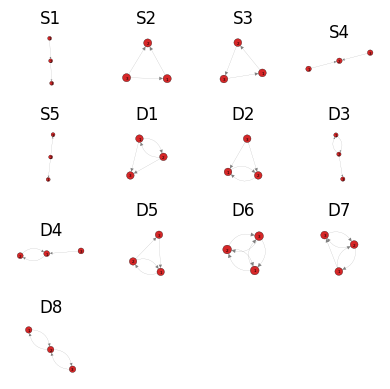

In [ ]:
#@title Motif dataset
fig, ax = plot_motif_dataset(load_motifs())
out_path = '../Motif graphs/motif_dataset.pdf'
create_folder(out_path)
fig.savefig(out_path)

In [ ]:
#@title Z-score heatmap
import seaborn as sns

out_folder = '../Motif graphs/' #@param {type:'string'}
df_z_score_all_path = '../Motif triad census pickles/z_score_swap_all.pickle' #@param {type:'string'}
df_z_score_living_path = '../Motif triad census pickles/z_score_swap_living.pickle' #@param {type:'string'}
for graph_type in ['all', 'living']:
  out_name = f'motif_heat_map_swap_{graph_type}.pdf'
  out_path = os.path.join(out_folder, out_name)
  create_folder(out_path)
  df_tc_z_score = pd.read_pickle(df_z_score_all_path) if graph_type == 'all' else pd.read_pickle(df_z_score_living_path)
  df_triad_census_z_score_vis = df_tc_z_score.iloc[:,1:].set_index('nickname').fillna(0)
  fig = sns.heatmap(df_triad_census_z_score_vis, vmin=-2, vmax = 2, cmap=sns.diverging_palette(20, 220, as_cmap=True)).get_figure()
  ax = fig.get_axes()
  ax[0].set_ylabel('Graph nickcname')
  ax[0].set_xlabel('Motif name')
  ax[0].set_title(f"Z-scores motifs swap - {graph_type}")

  fig.savefig(out_path)
  plt.clf()
  display(f'Image saved in {out_path}')

'Image saved in ../Motif graphs/motif_heat_map_swap_all.pdf'

'Image saved in ../Motif graphs/motif_heat_map_swap_living.pdf'

<Figure size 640x480 with 0 Axes>

'Image saved in ../Motif graphs/motif_profile_swap_living.pdf'

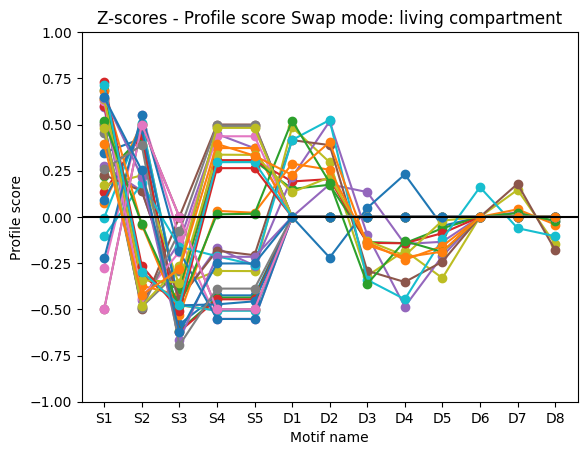

In [ ]:
out_folder = '../Motif graphs/' #@param {type:'string'}

df_tc_z_score_path = f'../Motif triad census pickles/z_score_swap_living.pickle' #@param {type:'string'}
out_path = os.path.join(out_folder, f'motif_profile_swap_living.pdf') #@param {type:'string'}
title = 'Z-scores - Profile score Swap mode: living compartment' #@param {type:'string'}
df_tc_z_score = pd.read_pickle(df_tc_z_score_path)
df_triad_census_z_score_vis = df_tc_z_score.iloc[:,1:].set_index('nickname').fillna(0)
df_triad_census_profile_score_z = df_triad_census_z_score_vis.iloc[:,:].apply(lambda x: x / np.sqrt(np.sum(x*x)), axis=1)
fig, ax = plt.subplots()

for row in df_triad_census_profile_score_z.iterrows():
  ax.plot(row[1].index, row[1].values, marker='o')
# ax.bar(x=series.index, height=series, color=cmap(norm(series)), yerr=err)
ax.set_ylabel('Profile score')
ax.set_xlabel('Motif name')
ax.set_title(title)
xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], color='black')
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(-1, 1)

fig.savefig(out_path)
display(f'Image saved in {out_path}')

<ipython-input-19-0b98d755d1c6>:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tc_z_score_corr.corr(),


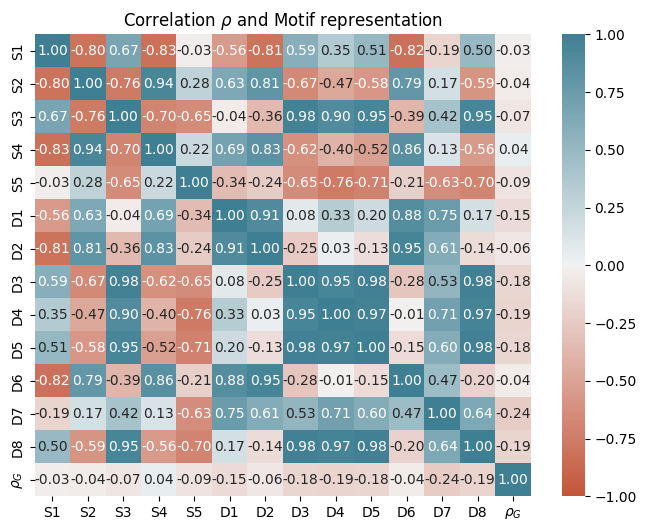

In [ ]:
#@title Correlations: Motif representation and robustness
#todo: una matrice di correlazione per ogni bioma (estuarine, +)
#todo: tabella con le freccie

df_robustness_filepath = 'Robustness and node sequence/robustness.pickle' #@param {type: "string"}
df_z_score_filepath = '../Motif triad census pickles/z_score_er_living.pickle' #@param {type: 'string'}
image_path = '../Motif graph/representation_vs_robustness_er_mode.pdf' #@param {type: "string"}
create_folder(image_path)

df_tc_z_score = pd.read_pickle(df_z_score_filepath)
df_robustness = pd.read_pickle(df_robustness_filepath)
available_graph = df_tc_z_score.graph_name.unique()
robustness = df_robustness.set_index('graph_name')['rho_G'][available_graph]
df_tc_z_score_corr = df_tc_z_score.set_index('graph_name')
df_tc_z_score_corr[r'$\rho_G$'] = robustness
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(df_tc_z_score_corr.corr(),
            vmin=-1, vmax = 1,
            cmap=sns.diverging_palette(20, 220, as_cmap=True),
            annot=True, fmt='.2f',
            ax = ax)
ax.set_title(r"Correlation $\rho$ and Motif representation")
fig.savefig(image_path)

<ipython-input-21-b527f8fc5bc3>:31: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tc_z_score_corr.corr(),


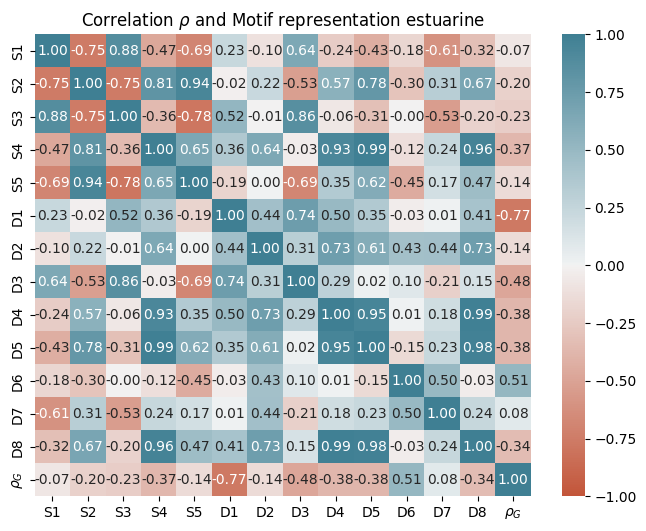

In [ ]:
#@title Correlations: Motif representation and robustness estuarine graphs

df_robustness_filepath = 'Robustness and node sequence/robustness.pickle' #@param {type: "string"}
df_z_score_filepath = '../Motif triad census pickles/z_score_er_all.pickle' #@param {type: 'string'}
image_path = '../Motif graph/representation_vs_robustness_er_mode_estuarine_all.pdf' #@param {type: "string"}
create_folder(image_path)

available_graphs = [
    'Chesapeake Bay Mesohaline',
    'Lower Chesapeake Bay',
    'Middle Chesapeake Bay',
    'Upper Chesapeake Bay',
    'Mangrove Estuary - Dry Season',
    'Mangrove Estuary - Wet Season',
    'Mondego Estuary - Zostrea site',
    'Narragansett Bay Model',
    'River Rheido, Wales',
    'Tagus estuary, Portugal',
    'Ythan estuary, Aberdeenshire, Scotland'
]

df_tc_z_score = pd.read_pickle(df_z_score_filepath)
df_robustness = pd.read_pickle(df_robustness_filepath)
df_tc_z_score = df_tc_z_score[df_tc_z_score['graph_name'].apply(lambda x: any(y in x for y in available_graphs))]
df_robustness = df_robustness[df_robustness['graph_name'].apply(lambda x: any(y in x for y in available_graphs))]

robustness = df_robustness.set_index('graph_name')['rho_G']
df_tc_z_score_corr = df_tc_z_score.set_index('graph_name')
df_tc_z_score_corr[r'$\rho_G$'] = robustness
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(df_tc_z_score_corr.corr(),
            vmin=-1, vmax = 1,
            cmap=sns.diverging_palette(20, 220, as_cmap=True),
            annot=True, fmt='.2f',
            ax = ax)
ax.set_title(r"Correlation $\rho$ and Motif representation estuarine")
fig.savefig(image_path)

<ipython-input-35-3351458c5b05>:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tc_z_score_corr.corr(),


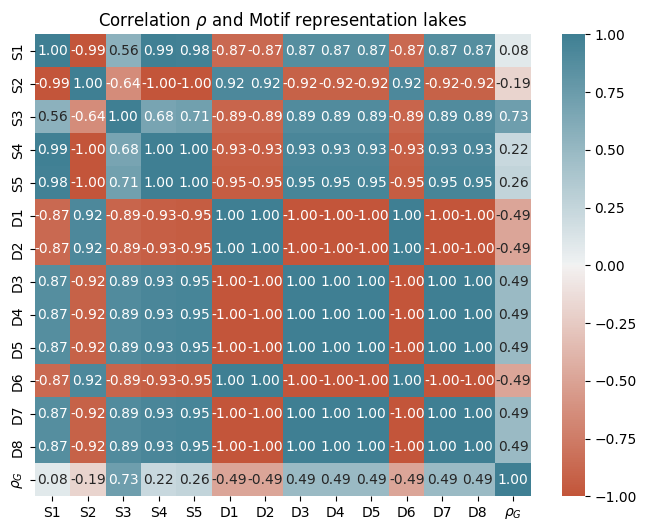

In [ ]:
#@title Correlations: Motif representation and robustness lake graphs

df_robustness_filepath = 'Robustness and node sequence/robustness.pickle' #@param {type: "string"}
df_z_score_filepath = '../Motif triad census pickles/z_score_swap_living.pickle' #@param {type: 'string'}
image_path = '../Motif graph/representation_vs_robustness_swap_mode_lake.pdf' #@param {type: "string"}
create_folder(image_path)

available_graphs = [
  'Lake Michigan',
  'Lake Paajarvi, littoral zone, Finland',
  'Lake Pyhajarvi, littoral zone, Finland',
  'Little Rock Lake, Wisconsin'
]

df_tc_z_score = pd.read_pickle(df_z_score_filepath)
df_robustness = pd.read_pickle(df_robustness_filepath)
df_tc_z_score = df_tc_z_score[df_tc_z_score['graph_name'].apply(lambda x: any(y in x for y in available_graphs))]
df_robustness = df_robustness[df_robustness['graph_name'].apply(lambda x: any(y in x for y in available_graphs))]

robustness = df_robustness.set_index('graph_name')['rho_G']
df_tc_z_score_corr = df_tc_z_score.set_index('graph_name')
df_tc_z_score_corr[r'$\rho_G$'] = robustness
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(df_tc_z_score_corr.corr(),
            vmin=-1, vmax = 1,
            cmap=sns.diverging_palette(20, 220, as_cmap=True),
            annot=True, fmt='.2f',
            ax = ax)
ax.set_title(r"Correlation $\rho$ and Motif representation lakes")
fig.savefig(image_path)

## Role of species in motifs

Lower Chesapeake Bay
Degree: 9
In-degree: 3
Out-Degree: 6
Betweenness: 18.285714285714285


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 6
In-degree: 3
Out-Degree: 3
Betweenness: 7.9523809523809526
Degree: 9
In-degree: 3
Out-Degree: 6
Betweenness: 9.833333333333334


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()
<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Middle Chesapeake Bay
Degree: 11
In-degree: 4
Out-Degree: 7
Betweenness: 29.9047619047619
Degree: 12
In-degree: 3
Out-Degree: 9
Betweenness: 26.285714285714285
Degree: 12
In-degree: 3
Out-Degree: 9
Betweenness: 18.333333333333332
Upper Chesapeake Bay
Degree: 11
In-degree: 4
Out-Degree: 7
Betweenness: 26.363636363636363
Degree: 12
In-degree: 3
Out-Degree: 9
Betweenness: 26.18181818181818
Degree: 9
In-degree: 4
Out-Degree: 5
Betweenness: 21.18181818181818


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Chesapeake Bay Mesohaline
Degree: 10
In-degree: 3
Out-Degree: 7
Betweenness: 41.300000000000004


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 9
In-degree: 3
Out-Degree: 6
Betweenness: 25.93333333333333
Degree: 7
In-degree: 0
Out-Degree: 7
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()
<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Crystal River Creek - Control
Degree: 6
In-degree: 0
Out-Degree: 6
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 5
In-degree: 5
Out-Degree: 0
Betweenness: 0.0
Degree: 9
In-degree: 8
Out-Degree: 1
Betweenness: 3.25


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()
<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Crystal River Creek - Delta Temp
Degree: 6
In-degree: 2
Out-Degree: 4
Betweenness: 4.333333333333333
Degree: 13
In-degree: 0
Out-Degree: 13
Betweenness: 0.0
Degree: 2
In-degree: 2
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Charca de Maspalomas
Degree: 6
In-degree: 6
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 3
In-degree: 2
Out-Degree: 1
Betweenness: 8.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 4
In-degree: 2
Out-Degree: 2
Betweenness: 8.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Lake Michigan
Degree: 17
In-degree: 6
Out-Degree: 11
Betweenness: 25.546969696969697
Degree: 17
In-degree: 6
Out-Degree: 11
Betweenness: 30.146969696969695
Degree: 17
In-degree: 6
Out-Degree: 11
Betweenness: 19.546969696969697
Mondego Estuary - Zostrea site
Degree: 22
In-degree: 10
Out-Degree: 12
Betweenness: 12.903571428571427
Degree: 25
In-degree: 15
Out-Degree: 10
Betweenness: 20.579761904761906
Degree: 7
In-degree: 0
Out-Degree: 7
Betweenness: 0.0
Narragansett Bay Model
Degree: 11
In-degree: 0
Out-Degree: 11
Betweenness: 0.0
Degree: 15
In-degree: 5
Out-Degree: 10
Betweenness: 18.60952380952381
Degree: 8
In-degree: 3
Out-Degree: 5
Betweenness: 25.191666666666666
St. Marks River (Florida)
Degree: 18
In-degree: 10
Out-Degree: 8
Betweenness: 26.144877344877344


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 10
In-degree: 10
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 18
In-degree: 9
Out-Degree: 9
Betweenness: 42.53968253968253
Arctic seas
Degree: 9
In-degree: 2
Out-Degree: 7
Betweenness: 18.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 2
In-degree: 0
Out-Degree: 2
Betweenness: 0.0
Degree: 4
In-degree: 1
Out-Degree: 3
Betweenness: 2.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()
<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Florida Bay - dry season
Degree: 69
In-degree: 15
Out-Degree: 54
Betweenness: 167.46691469351762
Degree: 39
In-degree: 39
Out-Degree: 0
Betweenness: 0.0
Degree: 40
In-degree: 5
Out-Degree: 35
Betweenness: 42.787223887223895
Florida Bay - wet season
Degree: 69
In-degree: 15
Out-Degree: 54
Betweenness: 169.3530949481945
Degree: 59
In-degree: 22
Out-Degree: 37
Betweenness: 133.54039206722425
Degree: 37
In-degree: 37
Out-Degree: 0
Betweenness: 0.0
Cypress Dry Season
Degree: 44
In-degree: 7
Out-Degree: 37
Betweenness: 230.92500000000007
Degree: 30
In-degree: 12
Out-Degree: 18
Betweenness: 43.486512054173964
Degree: 28
In-degree: 9
Out-Degree: 19
Betweenness: 43.34365491131682
Cypress Wet Season
Degree: 44
In-degree: 7
Out-Degree: 37
Betweenness: 230.59215686274513
Degree: 38
In-degree: 24
Out-Degree: 14
Betweenness: 137.16302521008402
Degree: 30
In-degree: 12
Out-Degree: 18
Betweenness: 37.719589414713276
Lake Paajarvi, littoral zone, Finland
Degree: 4
In-degree: 4
Out-Degree: 0
Betweenness

<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 8
In-degree: 2
Out-Degree: 6
Betweenness: 14.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 7
In-degree: 6
Out-Degree: 1
Betweenness: 3.2500000000000004


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Lake Pyhajarvi, littoral zone, Finland
Degree: 1
In-degree: 0
Out-Degree: 1
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 10
In-degree: 1
Out-Degree: 9
Betweenness: 9.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 7
In-degree: 7
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Everglades Graminoids
Degree: 22
In-degree: 0
Out-Degree: 22
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 21
In-degree: 0
Out-Degree: 21
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 17
In-degree: 0
Out-Degree: 17
Betweenness: 0.0
Little Rock Lake, Wisconsin
Degree: 92
In-degree: 84
Out-Degree: 8
Betweenness: 366.0911182335837
Degree: 85
In-degree: 77
Out-Degree: 8
Betweenness: 293.8329438480722
Degree: 87
In-degree: 79
Out-Degree: 8
Betweenness: 184.06465939610072


<ipython-input-105-9e7269009046>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize = (11.7, 8.3))


Tasek Bera swamp, Malaysia
Degree: 10
In-degree: 8
Out-Degree: 2
Betweenness: 21.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 7
In-degree: 5
Out-Degree: 2
Betweenness: 9.333333333333332
Degree: 4
In-degree: 4
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()
<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Mangrove Estuary - Dry Season
Degree: 40
In-degree: 0
Out-Degree: 40
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 27
In-degree: 27
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 25
In-degree: 5
Out-Degree: 20
Betweenness: 17.268461930226636


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Mangrove Estuary - Wet Season
Degree: 41
In-degree: 0
Out-Degree: 41
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 28
In-degree: 28
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 51
In-degree: 41
Out-Degree: 10
Betweenness: 82.85811783516384
River Rheido, Wales
Degree: 10
In-degree: 8
Out-Degree: 2
Betweenness: 3.5


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 9
In-degree: 9
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 9
In-degree: 0
Out-Degree: 9
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Rocky shore, Monterey Bay, California
Degree: 10
In-degree: 10
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 16
In-degree: 10
Out-Degree: 6
Betweenness: 18.694047619047616


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 15
In-degree: 9
Out-Degree: 6
Betweenness: 15.703571428571427


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Salt meadow, New Zealand
Degree: 5
In-degree: 0
Out-Degree: 5
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 6
In-degree: 1
Out-Degree: 5
Betweenness: 5.0
Degree: 4
In-degree: 0
Out-Degree: 4
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()
<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Sand beach, South Africa
Degree: 4
In-degree: 3
Out-Degree: 1
Betweenness: 4.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 3
In-degree: 1
Out-Degree: 2
Betweenness: 3.0
Degree: 3
In-degree: 3
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()
<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Shallow sublittoral, Cape Ann, Massachusetts
Degree: 11
In-degree: 10
Out-Degree: 1
Betweenness: 12.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 6
In-degree: 0
Out-Degree: 6
Betweenness: 0.0
Degree: 2
In-degree: 2
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()
<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Swamp, south Florida
Degree: 8
In-degree: 4
Out-Degree: 4
Betweenness: 23.5


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 7
In-degree: 1
Out-Degree: 6
Betweenness: 7.766666666666666
Degree: 5
In-degree: 2
Out-Degree: 3
Betweenness: 14.333333333333332


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()
<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Tagus estuary, Portugal 
Degree: 9
In-degree: 9
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 14
In-degree: 13
Out-Degree: 1
Betweenness: 5.098917748917749
Degree: 4
In-degree: 0
Out-Degree: 4
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Tropical plankton community, Pacific
Degree: 10
In-degree: 10
Out-Degree: 0
Betweenness: 0.0


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Degree: 16
In-degree: 10
Out-Degree: 6
Betweenness: 18.694047619047616
Degree: 15

<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()



In-degree: 9
Out-Degree: 6
Betweenness: 15.703571428571427


<ipython-input-4-6285697bd4ff>:12: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  eigenvector = g.eigenvector_centrality()


Ythan estuary, Aberdeenshire, Scotland
Degree: 32
In-degree: 14
Out-Degree: 18
Betweenness: 232.33506493506488
Degree: 30
In-degree: 10
Out-Degree: 20
Betweenness: 460.07142857142856
Degree: 27
In-degree: 18
Out-Degree: 9
Betweenness: 134.41481488927306


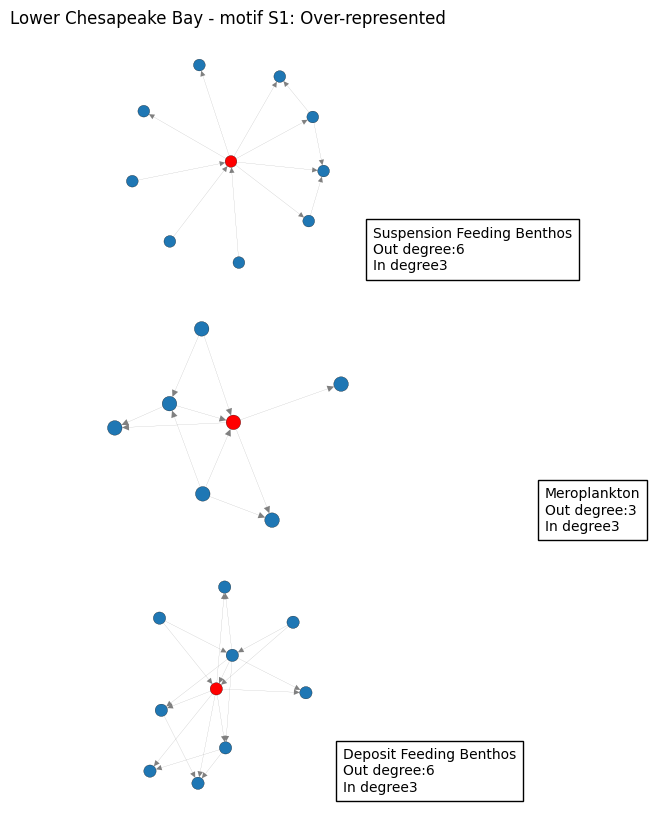

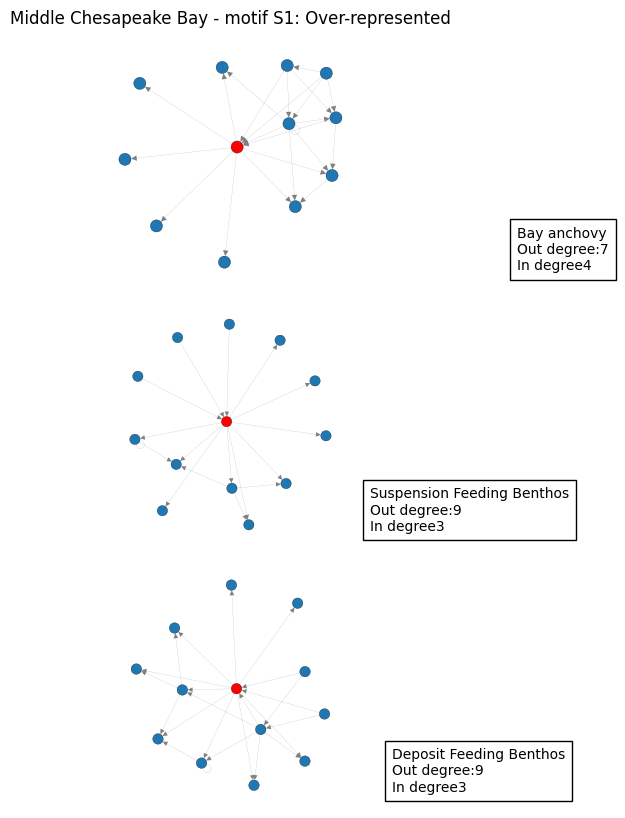

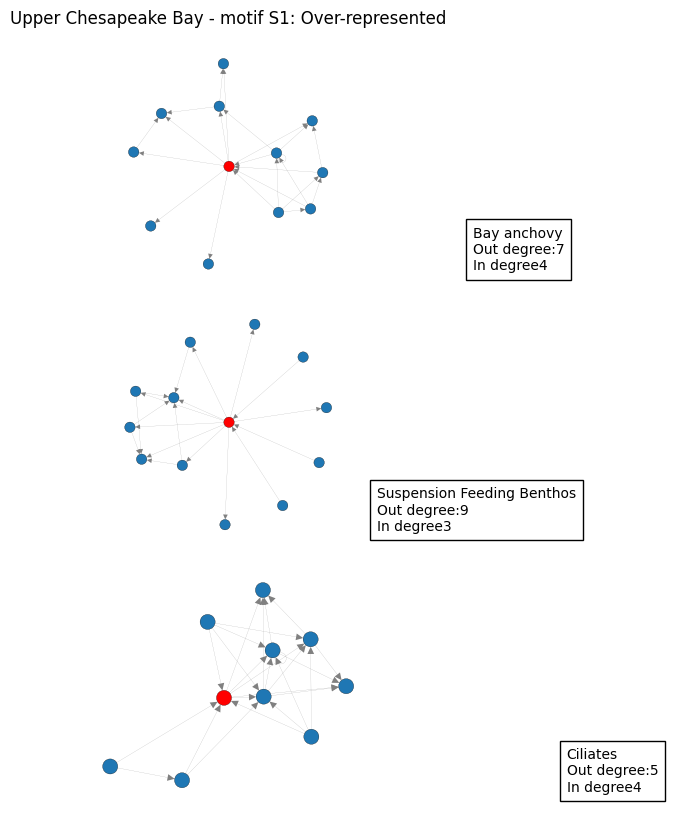

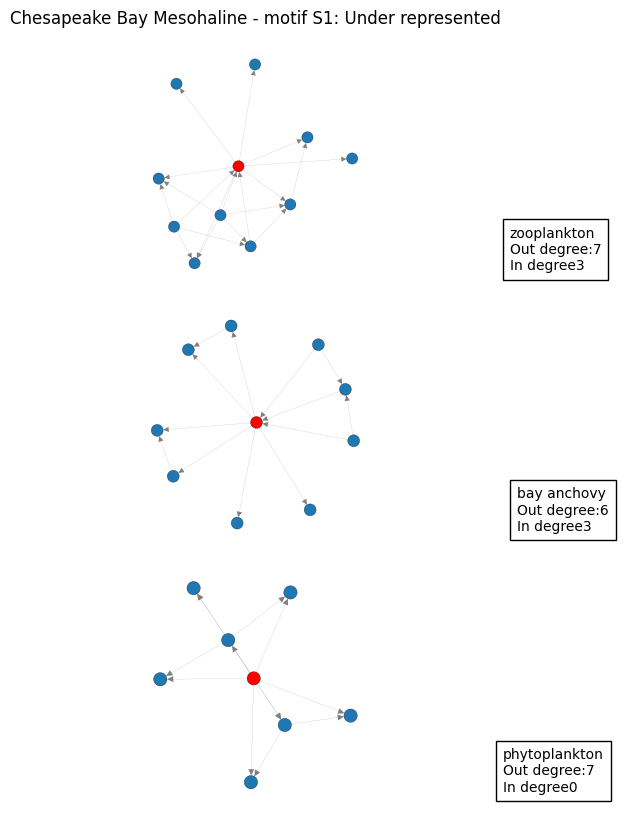

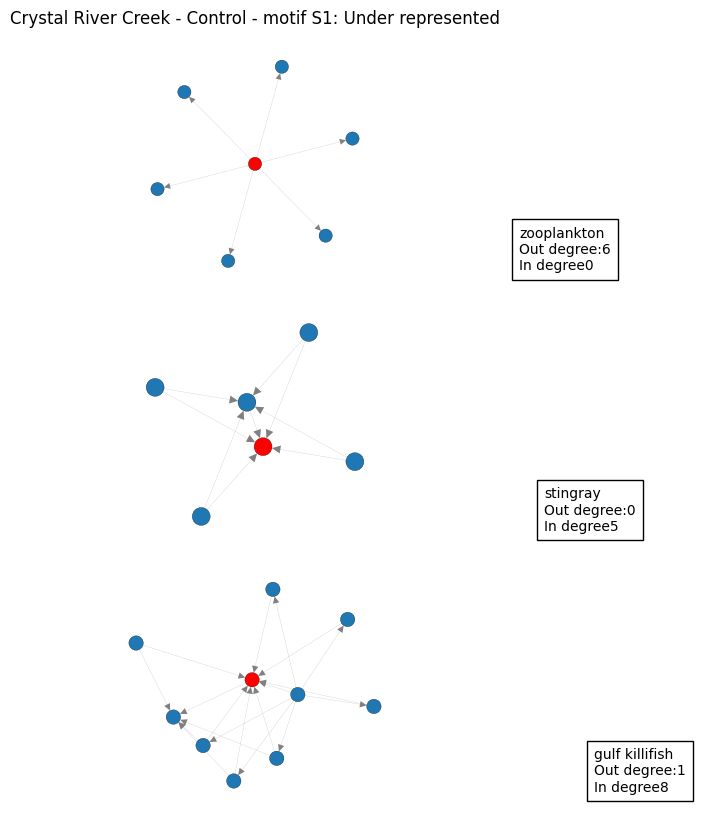

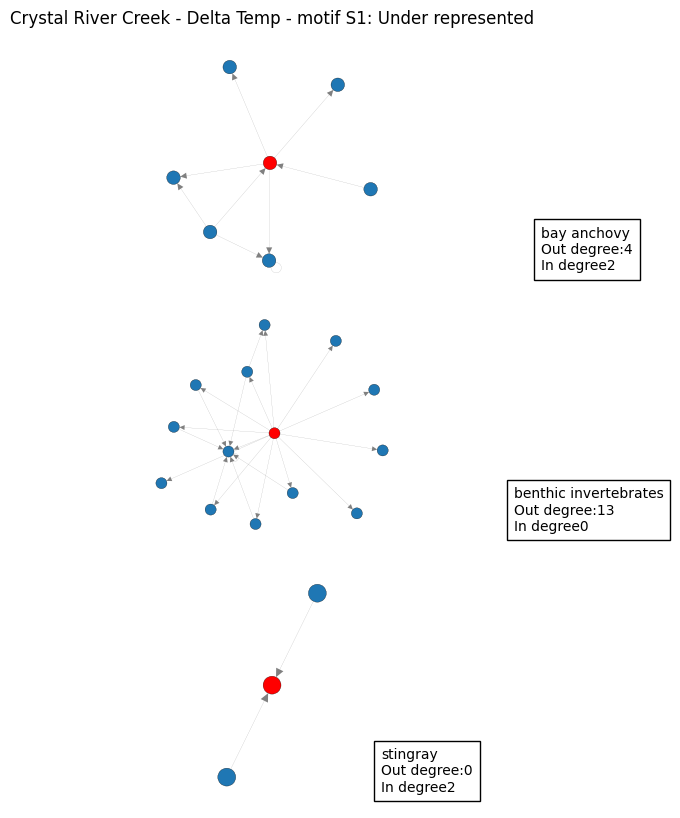

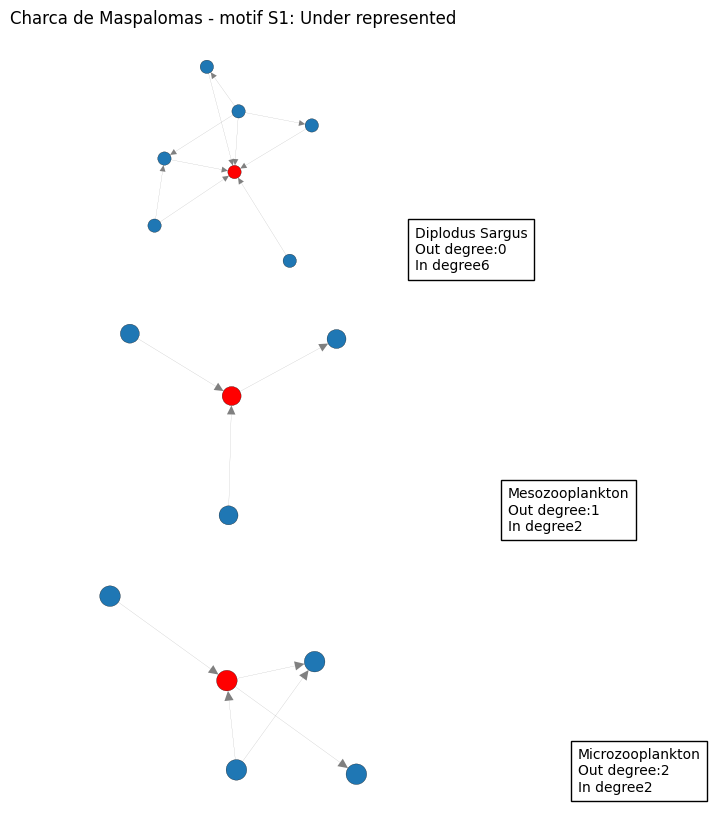

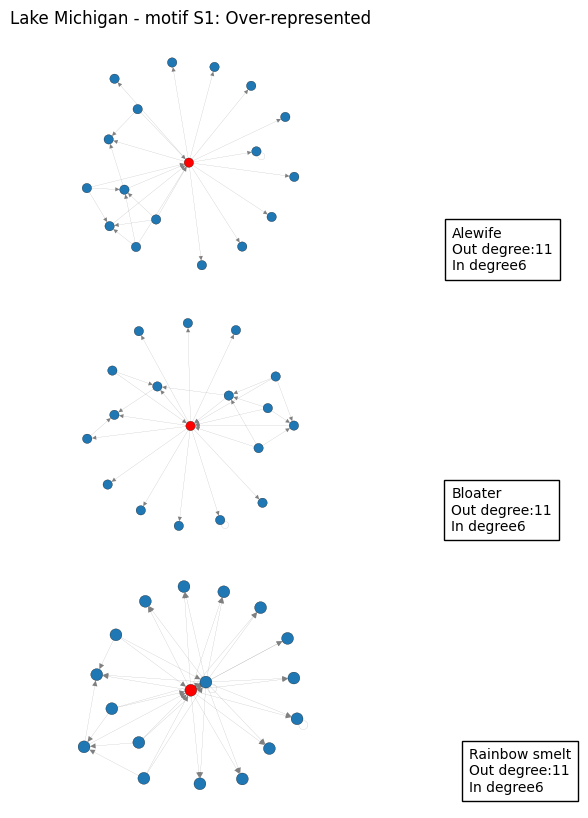

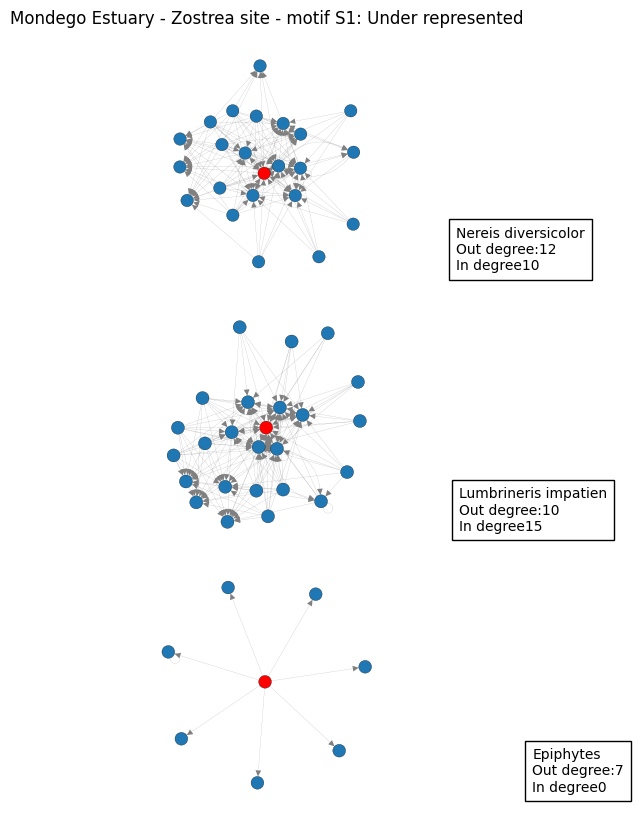

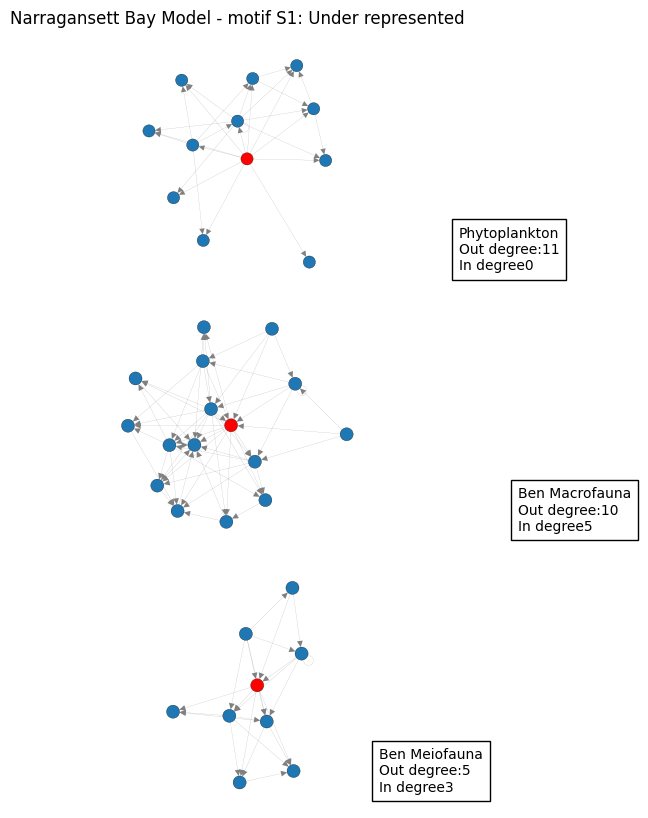

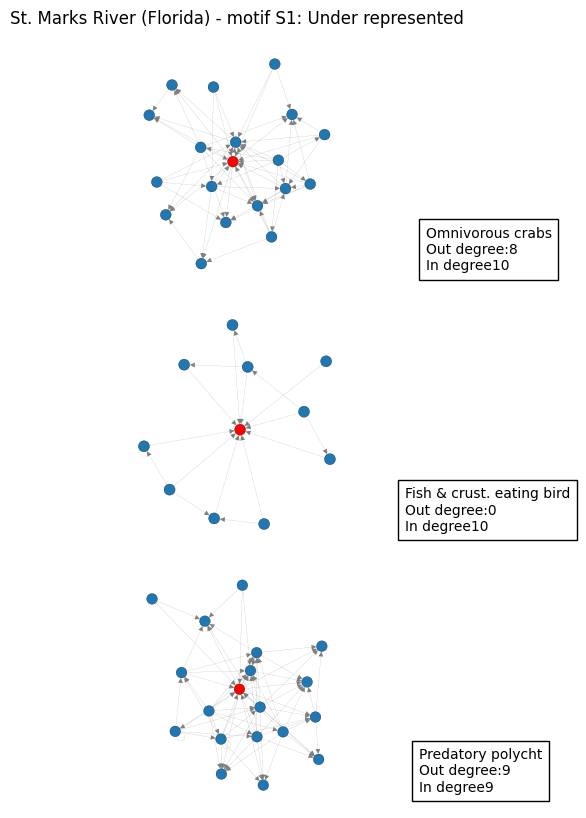

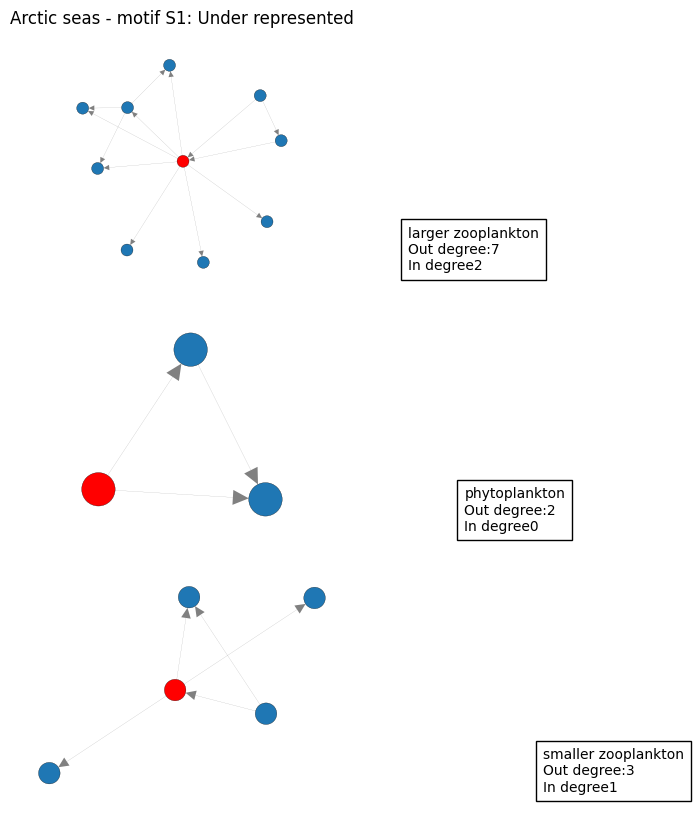

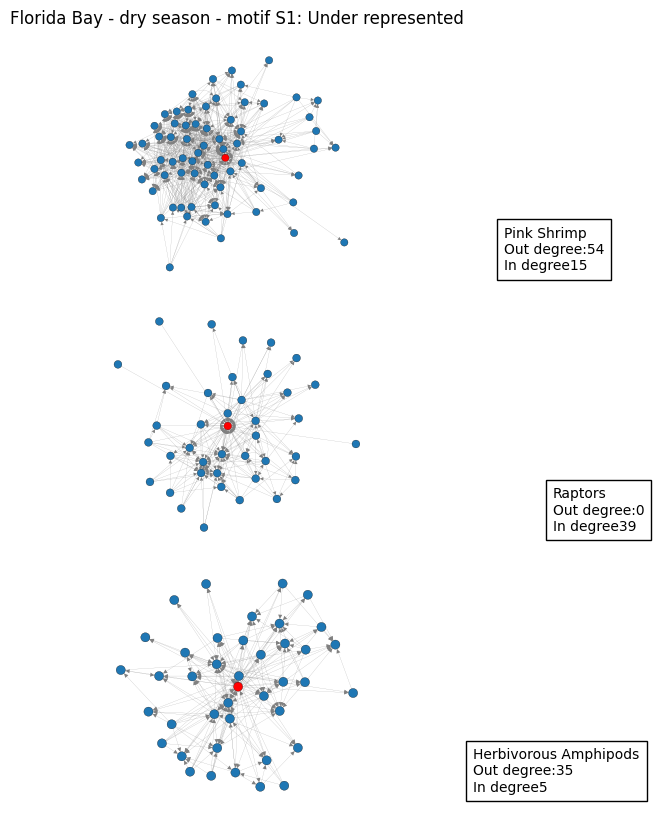

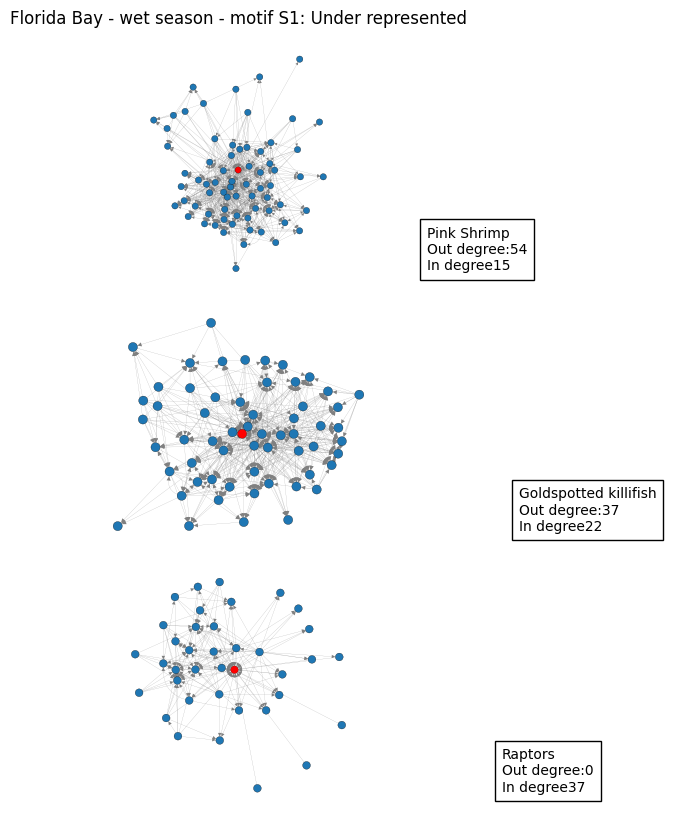

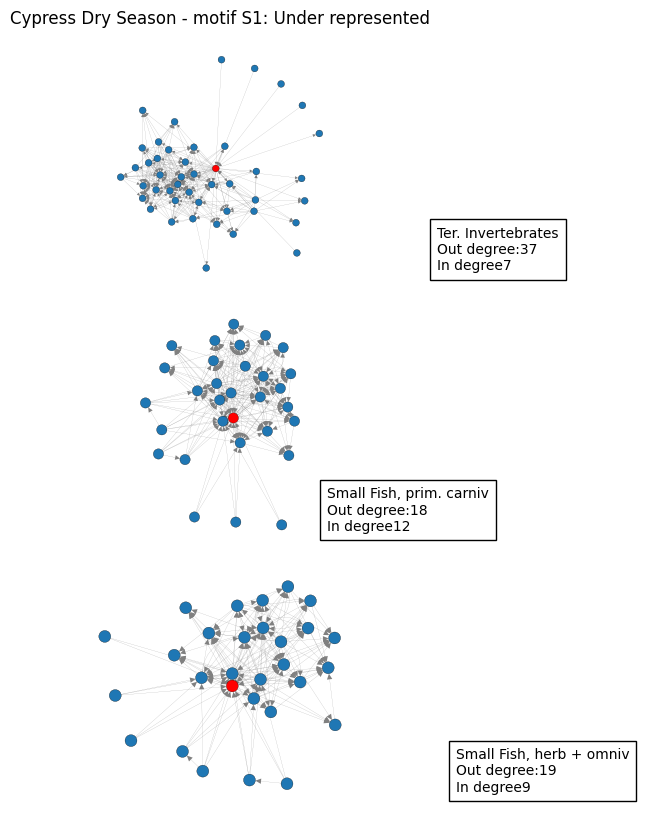

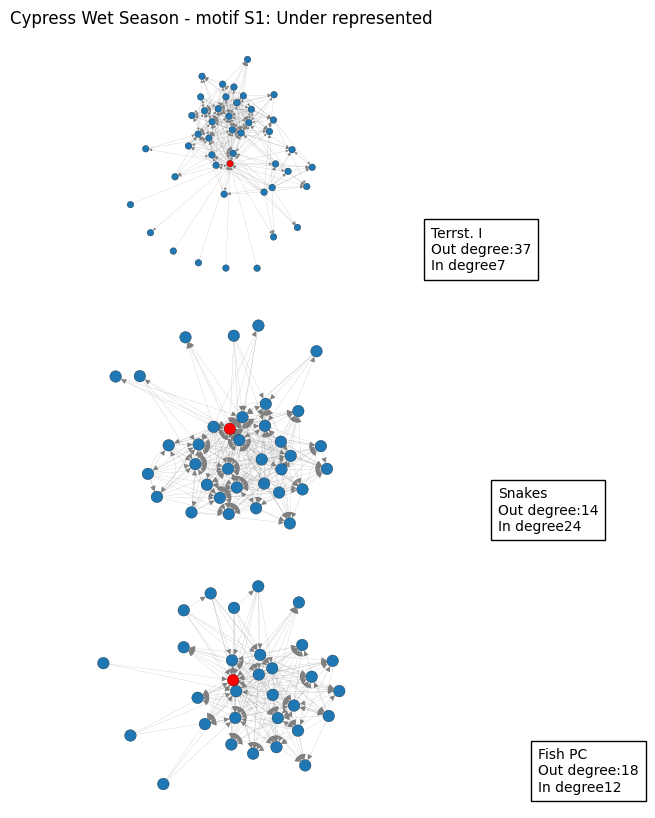

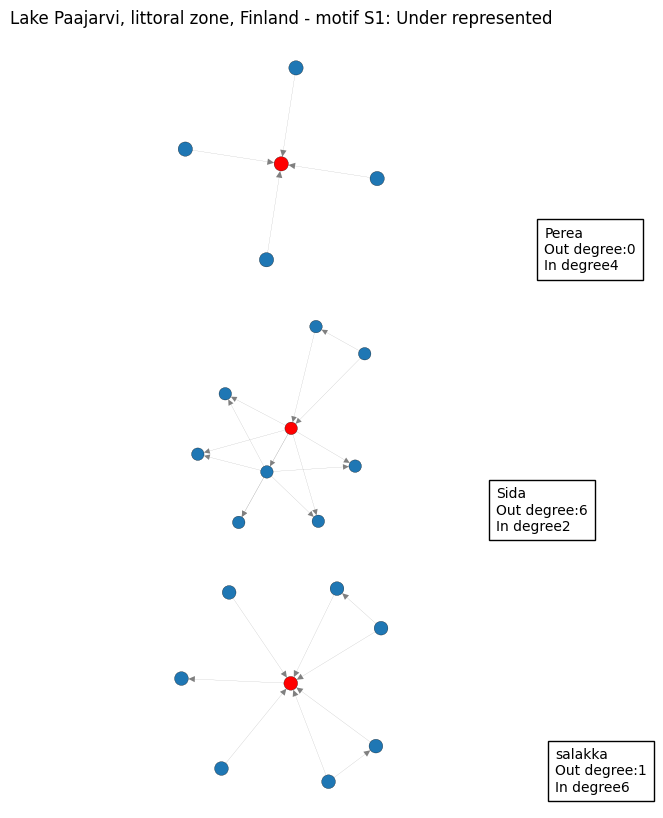

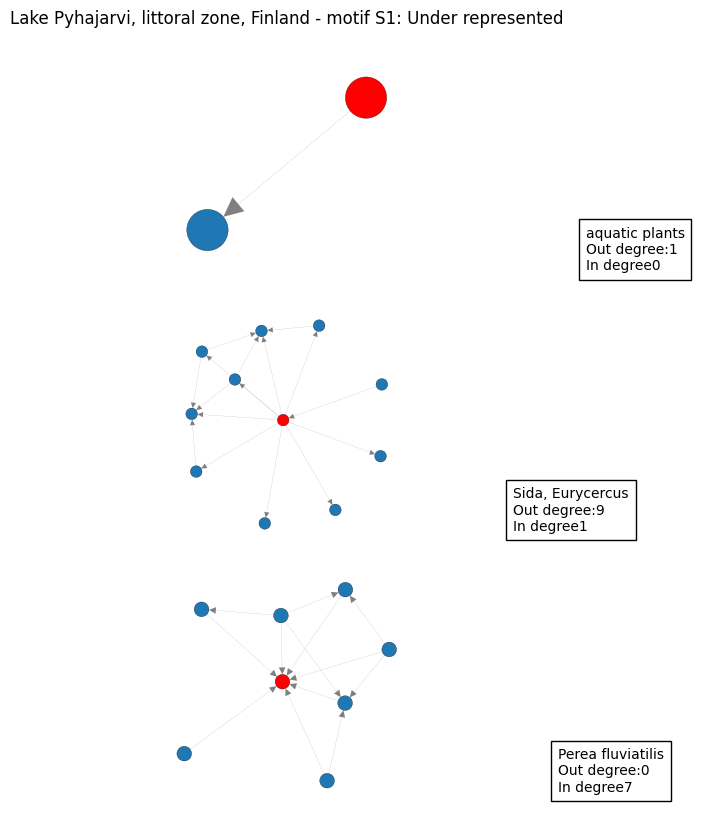

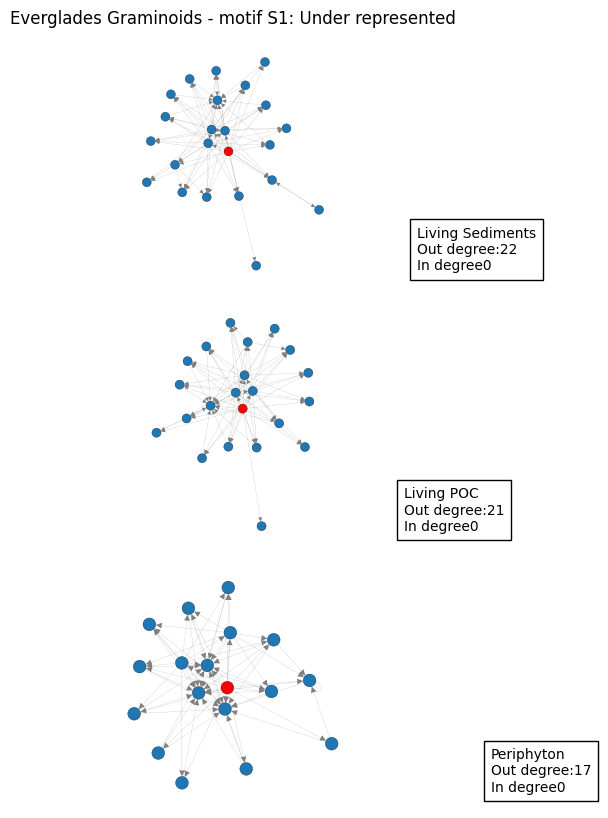

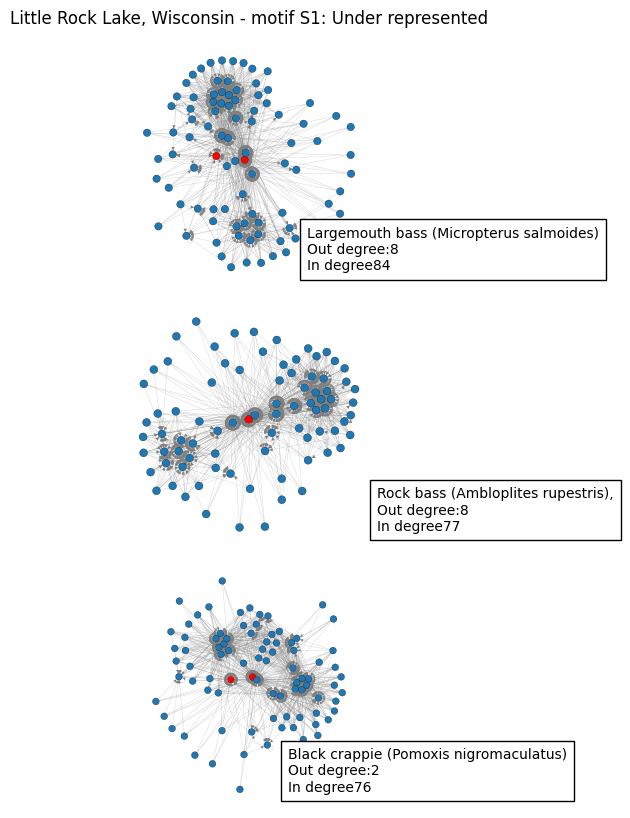

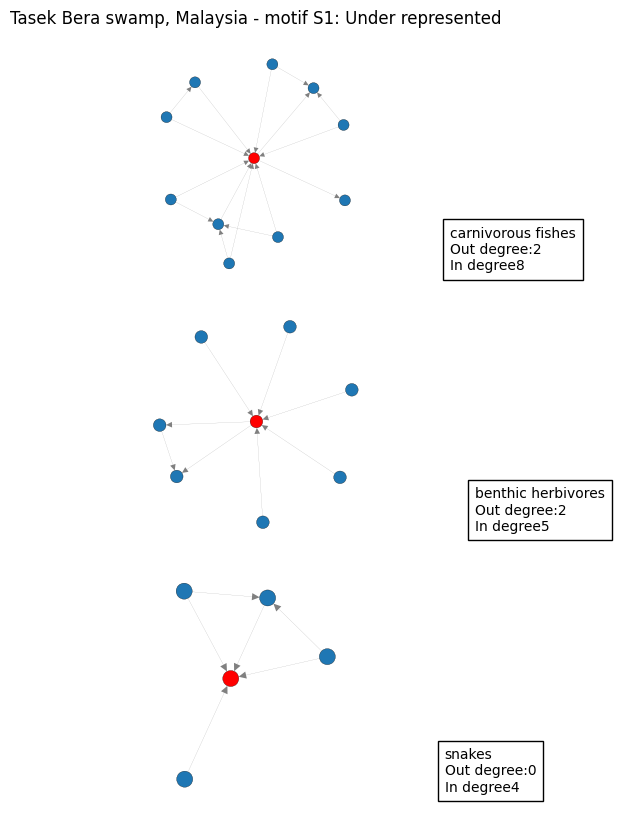

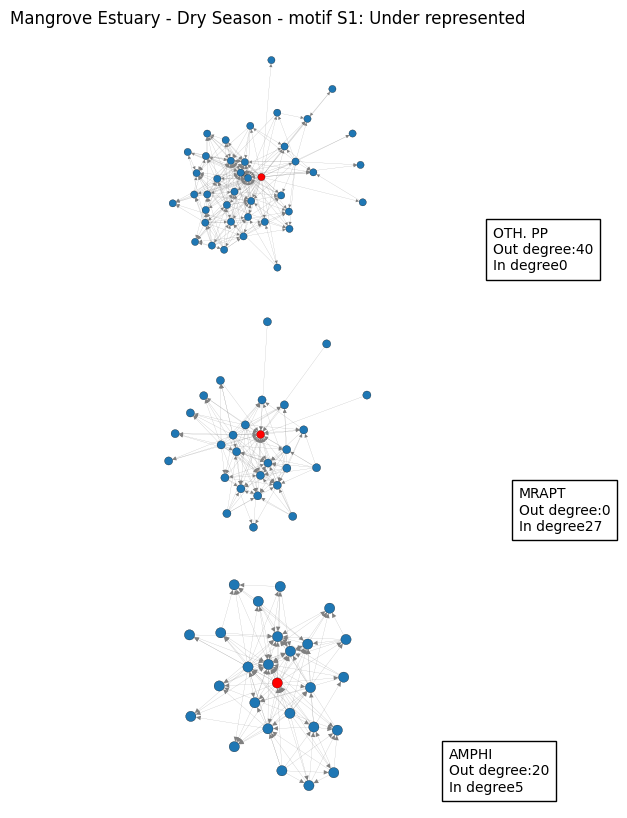

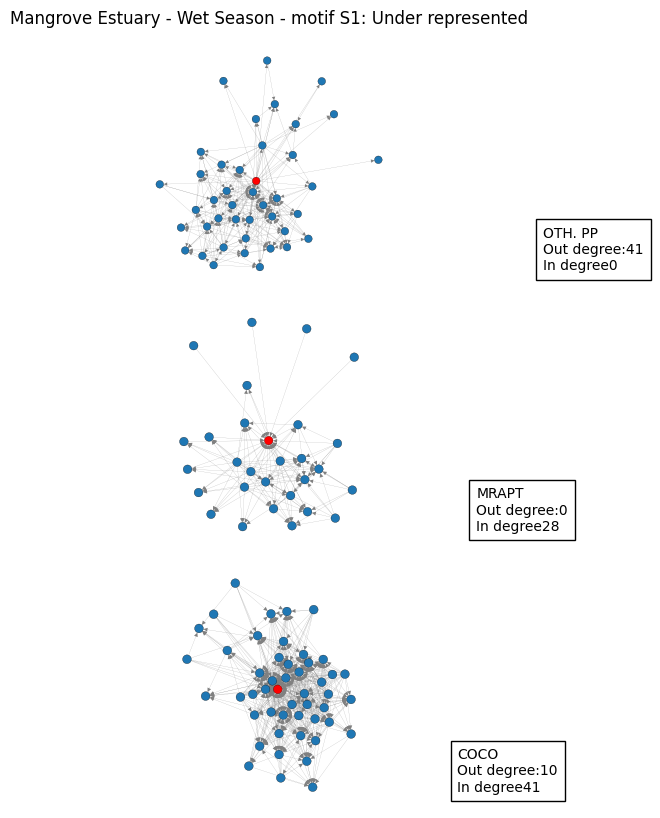

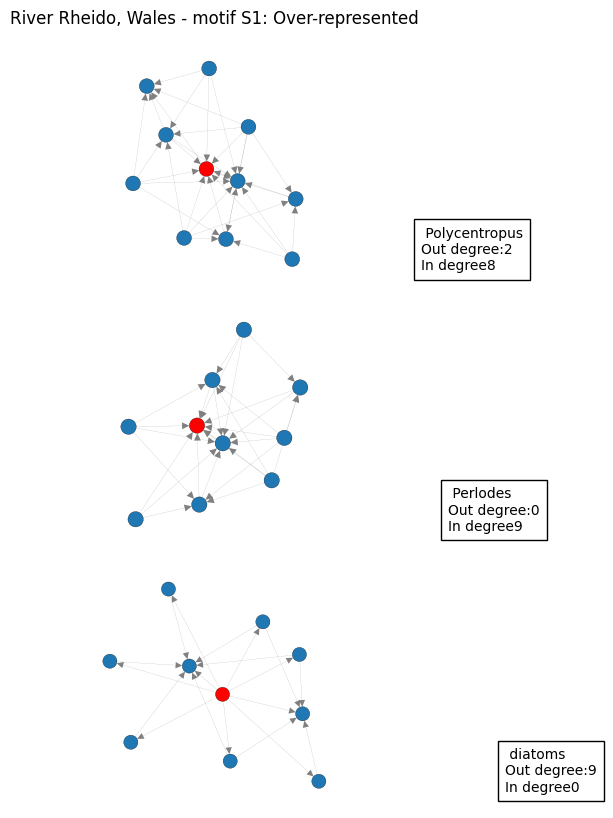

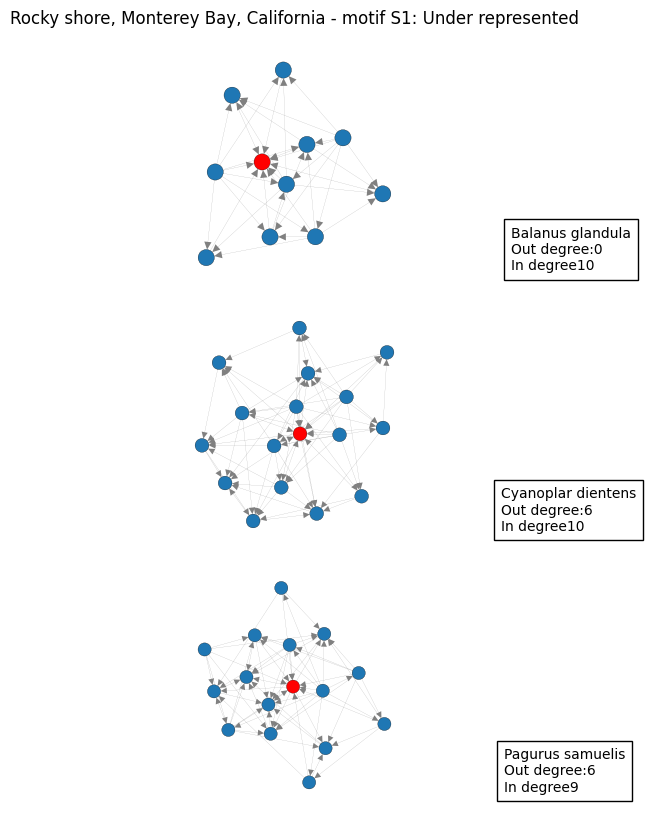

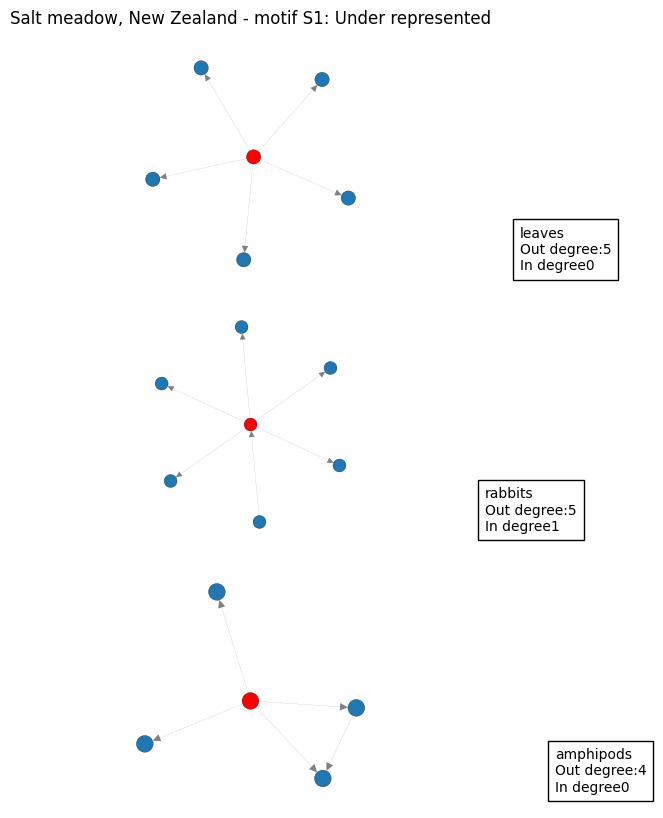

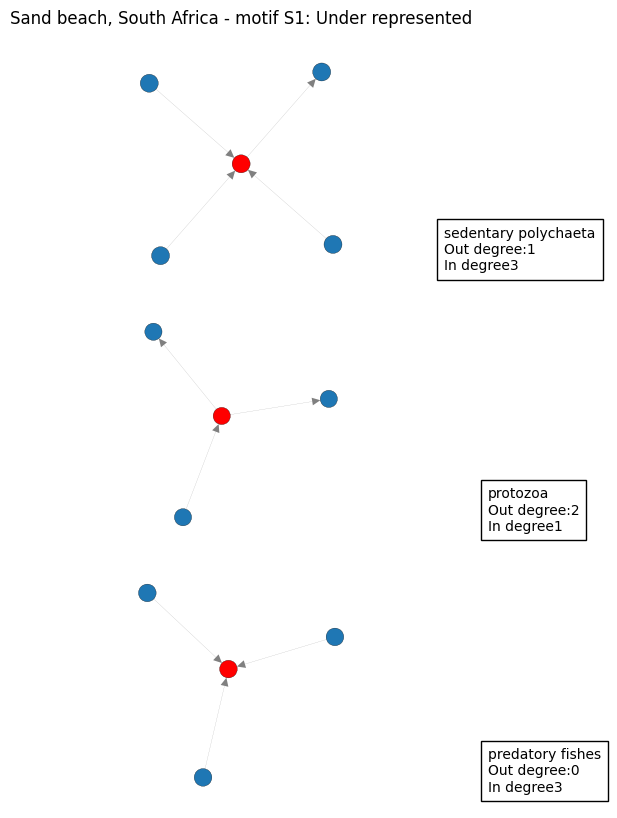

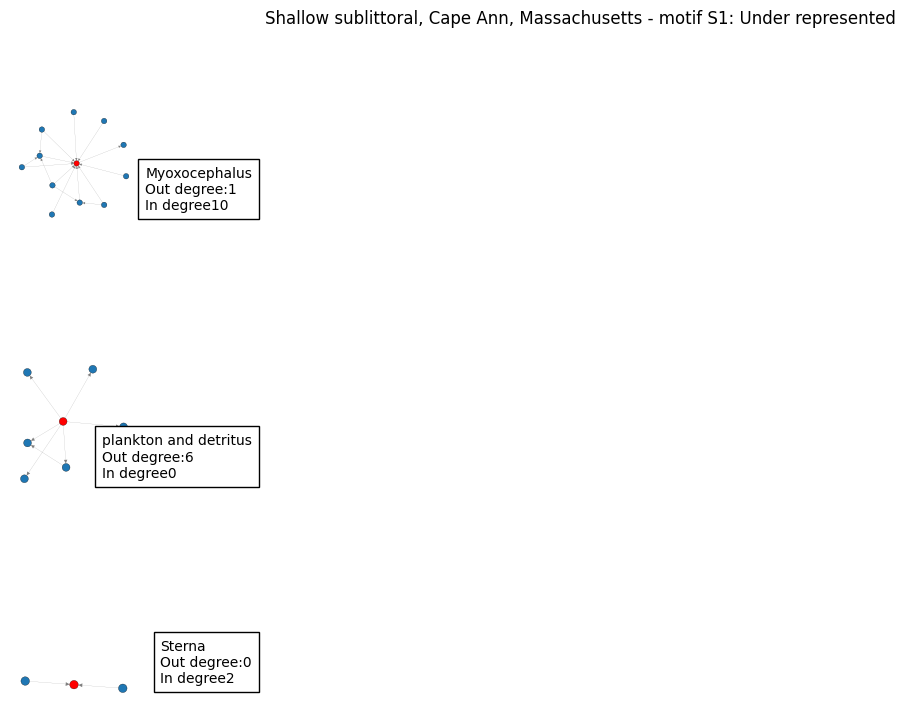

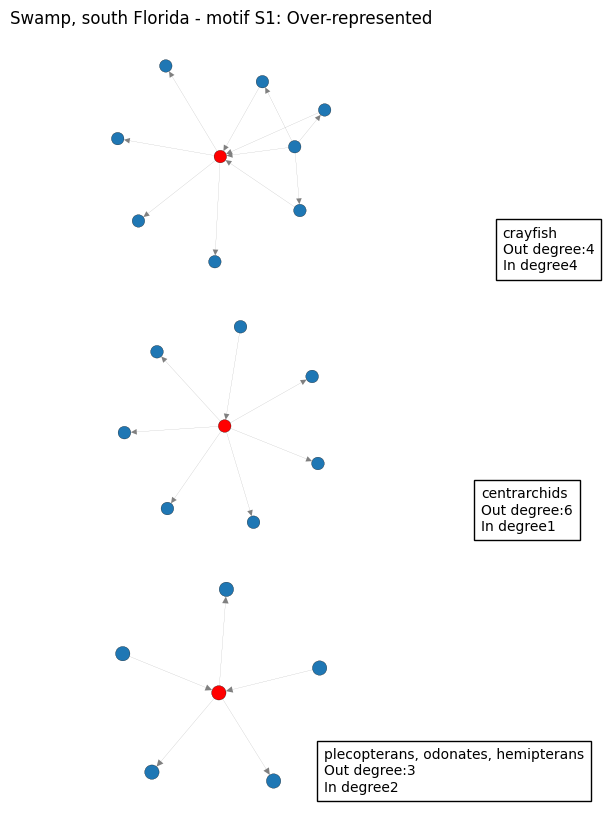

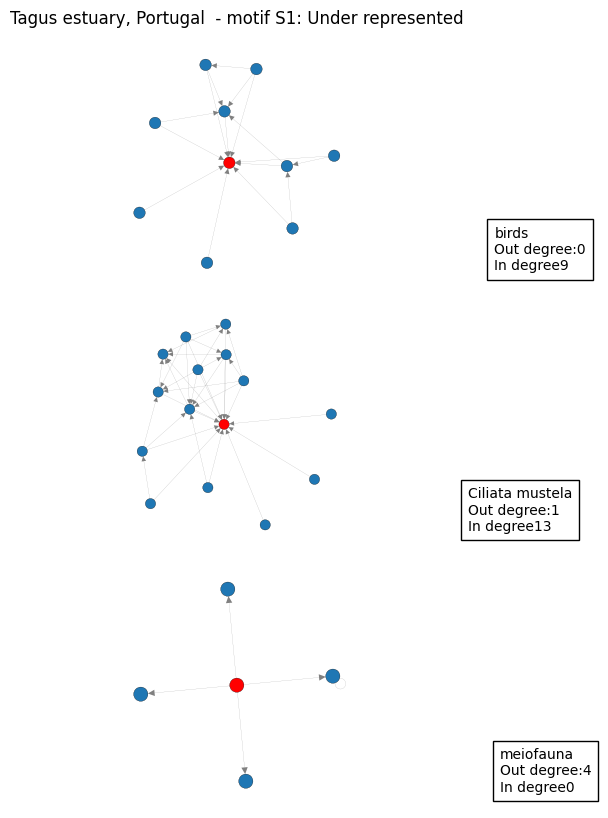

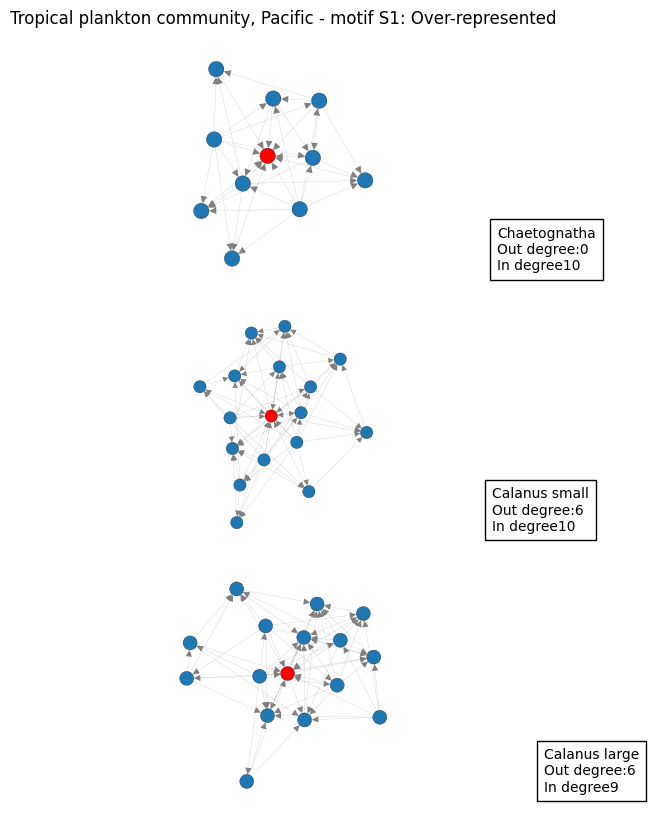

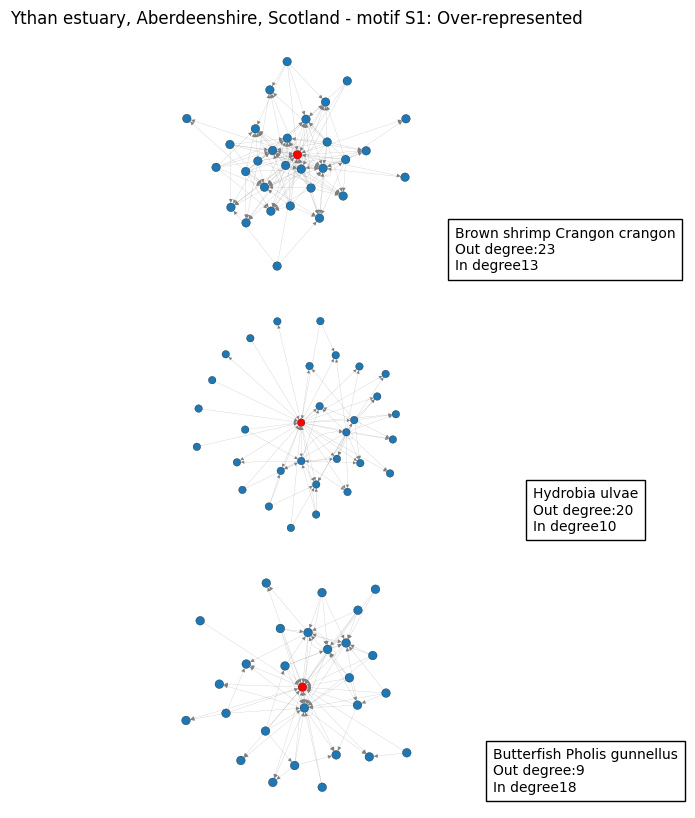

In [ ]:
from collections import Counter
from matplotlib.offsetbox import AnchoredText

motif = 'S1'
for G in G_dataset:
  if float(df_real_tc_living[df_real_tc_living['graph_name'] == G['name']][motif]) > float(df_er_tc_living[df_er_tc_living['graph_name'] == G['name']][motif]):
    rep = "Over-represented"
  else:
    rep = "Under represented"
  fig, axs = plt.subplots(3, 1, figsize = (11.7, 8.3))
  fig.suptitle(f"{G['name']} - motif {motif}: {rep}")
  v_living = [v for v in G.vs() if v['ECO'] == 1]
  G_living = G.subgraph(v_living)
  triads_census = motif_contained_in_G(G_living)[0]
  S1 = [element for triad in triads_census[motif]['triads']  for element in list(triad)]
  unique, counts = np.unique(S1, return_counts=True)
  # Get the max value index
  v_id_sorted = [el[0] for el in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)]
  # Get the name
  print(G['name'])

  for i in range(3):
    v_id = v_id_sorted[i]
    G_s = ego_net(G_living, G_living.vs()[v_id]['name'])
    vs = visual_style(G_s)
    vs['vertex_color'] = [vs['vertex_color'][i] if vs['vertex_label'][i] != G_living.vs()[v_id]['name'] else '#ff0000' for i in range(len(vs['vertex_color']))]
    vs['vertex_label'] = [None for v in G_s.vs()]
    ig.plot(G_s, target=axs[i], **vs)
    box_text = f"{G_living.vs()[v_id]['name']}\nOut degree:{G_living.vs()[v_id].outdegree()}\nIn degree{G_living.vs()[v_id].indegree()}"
    text = AnchoredText(box_text, frameon=True, loc='lower right', pad=0.5, bbox_transform=axs[i].transAxes, bbox_to_anchor=(2.,0.))
    axs[i].add_artist(text)
    fig.tight_layout()
    fig.savefig(f"/content/motif/{motif}_{G['name']}.pdf")


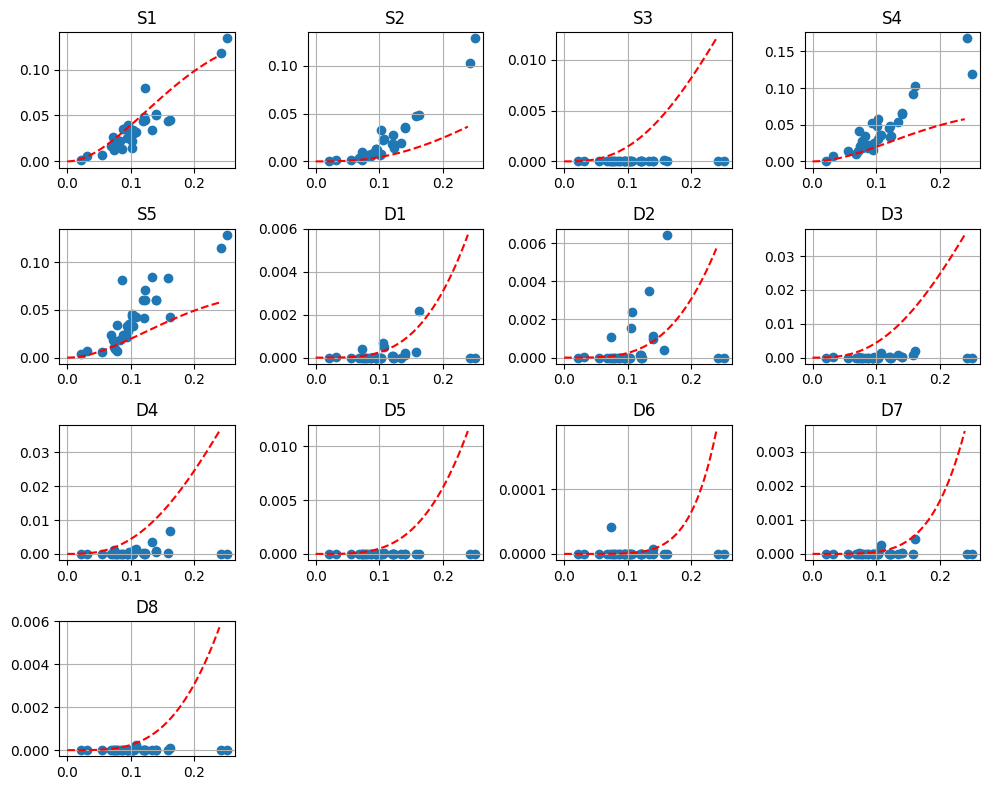

In [ ]:
#@title Motif probability vs Connectance, Link density, number of *species*

C = [] #init connectance array
p_link_er = []
S = [] #init species array
l = [] #init link density array
triads = []
for graph_name in df_real_tc_living.graph_name: # query the graphs name
  G = G_living_compartment_dataset[index_from_dataset(G_dataset, graph_name)] # query the graph
  S_G = G.vcount()
  L_G = G.ecount()
  S.append(S_G)
  C.append(L_G / (S_G * S_G))
  p_link_er.append(L_G / (S_G * (S_G - 1)))
  l.append(L_G / S_G)
  triads.append(S_G * (S_G - 1) * (S_G - 2) / 6)

df_real_tc_living_values = df_real_tc_living.drop('graph_name', axis=1)
y_vars = df_real_tc_living_values.columns
df_real_tc_living_values = df_real_tc_living_values.div(triads, axis = 0)
df_real_tc_living_values['graph_name'] = df_real_tc_living['graph_name']
df_real_tc_living_values['S'] = S
df_real_tc_living_values['C'] = C
df_real_tc_living_values['l'] = l
df_real_tc_living_values['p'] = p_link_er

rows = 4
cols = 4
fig, axs = plt.subplots(rows, cols, figsize = (10,8))
prob_motif = get_probability_for_motifs()
x_f = np.linspace(0, max(C), num=50)

for i, motif_name in enumerate(y_vars):
  icol = i % rows
  irow = i // rows
  axs[irow, icol].scatter(df_real_tc_living_values['p'], df_real_tc_living_values[motif_name])
  axs[irow, icol].plot(x_f, prob_motif[motif_name](x_f), color = 'r', linestyle= '--')
  axs[irow, icol].set_title(motif_name)
  axs[irow, icol].grid()

for j in range(i+1, rows*cols):
  icol = j % rows
  irow = j // rows
  axs[irow, icol].axis('off')
out_path = '../Motif graphs/motif_vs_connectance_linkdens.pdf'
create_folder(out_path)
fig.tight_layout()

# Species role in motifs

In [ ]:
#@title Querying the most frequent nodes
rows = []
for G in G_living_compartment_dataset:
  for v in G.vs():
    rows.append(tuple([v['name'].lower().replace(' ', ''), G['name']]))

df = pd.DataFrame(rows,columns=['taxa', 'graph_name'])
taxa = df['taxa']
print(taxa.value_counts()[:10])

phytoplankton    12
bayanchovy        9
meiofauna         8
catfish           7
zooplankton       7
freebacteria      6
spot              6
menhaden          5
bluecrab          5
epiphytes         5
Name: taxa, dtype: int64


<Figure size 640x480 with 0 Axes>

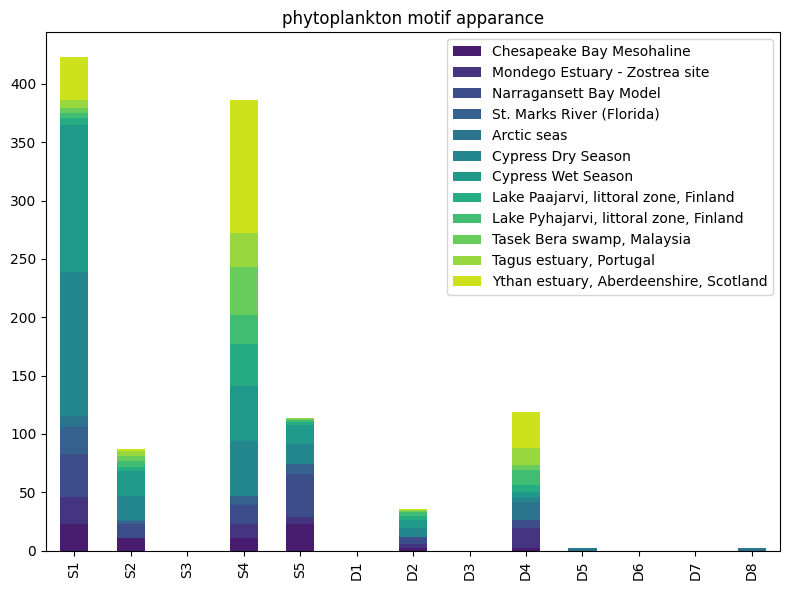

<Figure size 640x480 with 0 Axes>

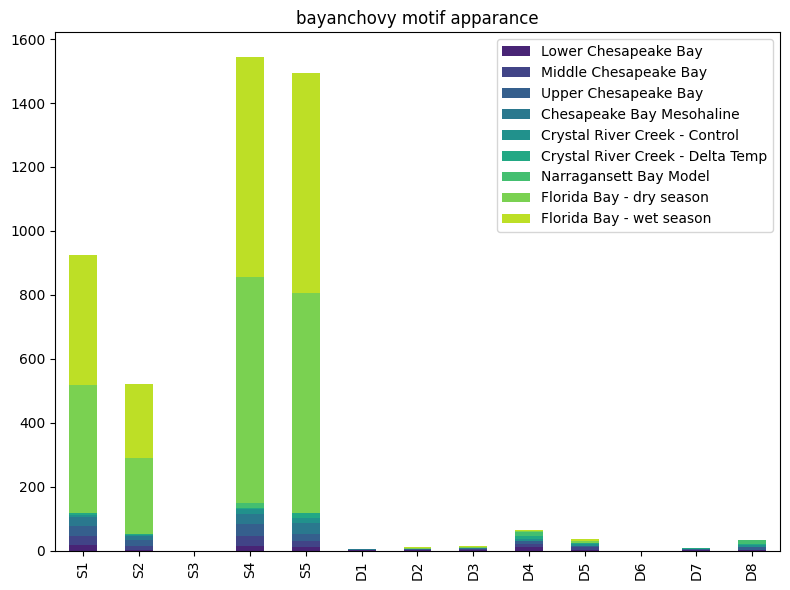

<Figure size 640x480 with 0 Axes>

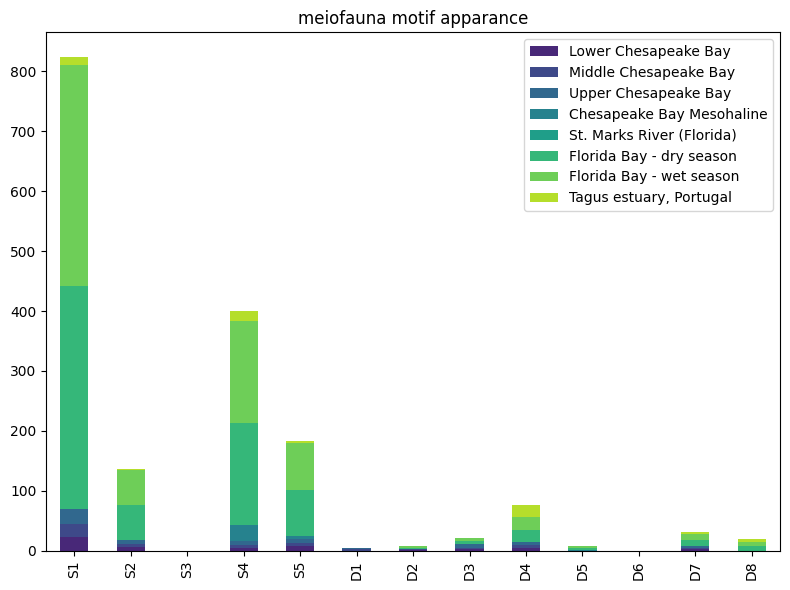

<Figure size 640x480 with 0 Axes>

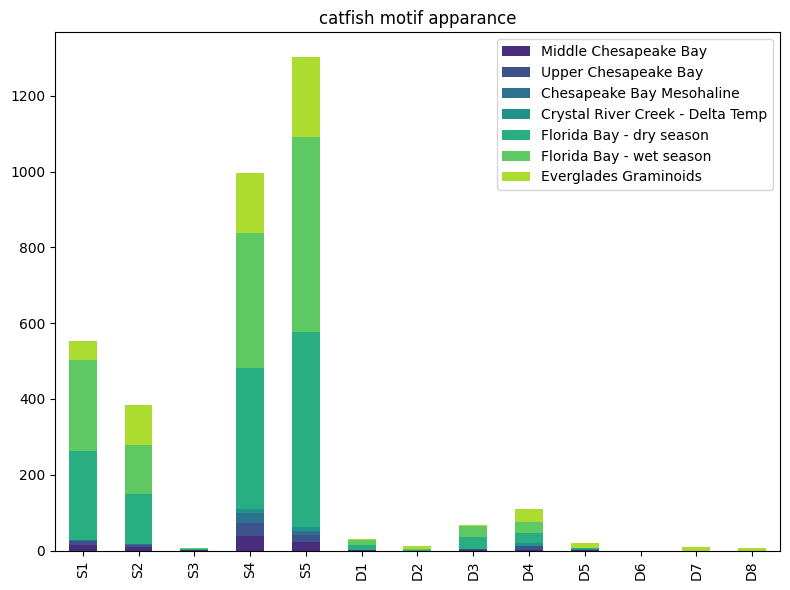

<Figure size 640x480 with 0 Axes>

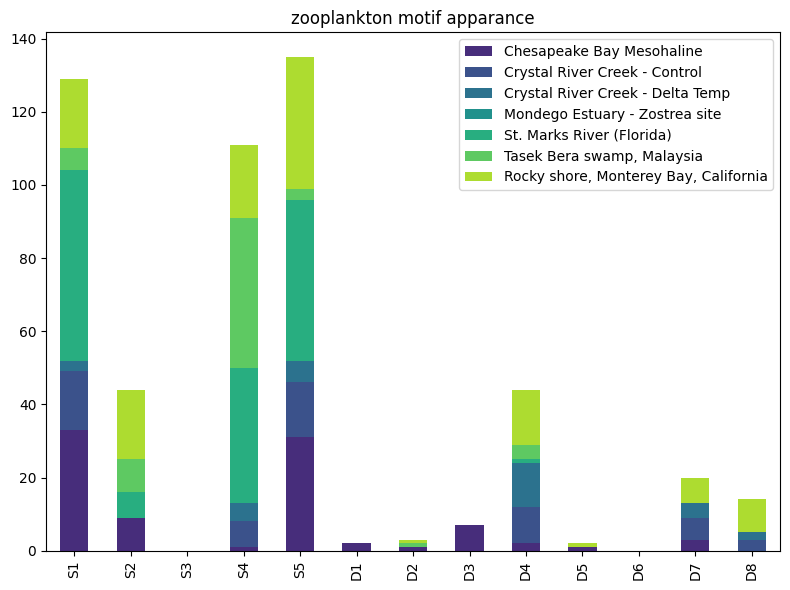

<Figure size 640x480 with 0 Axes>

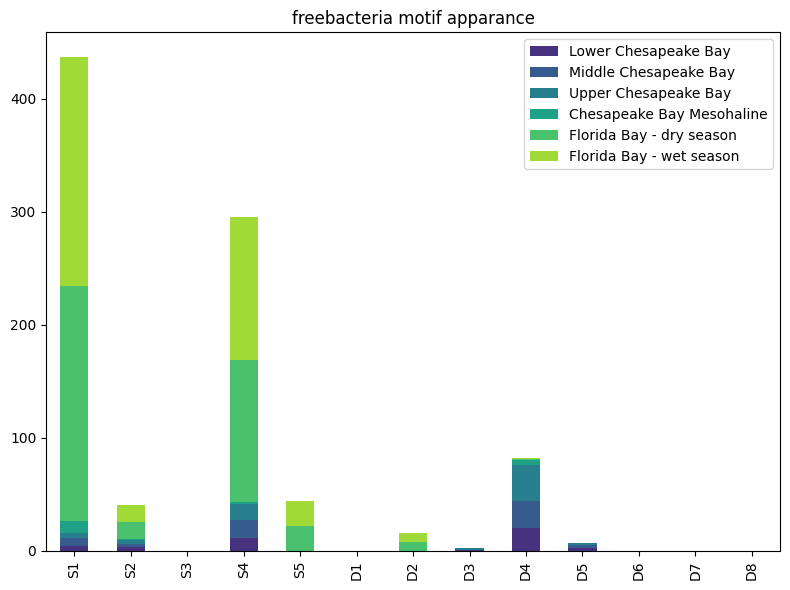

<Figure size 640x480 with 0 Axes>

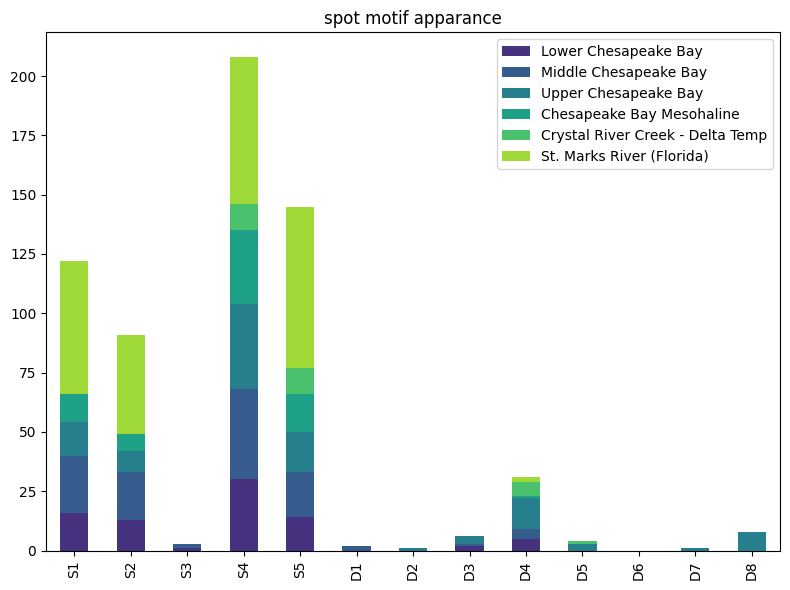

<Figure size 640x480 with 0 Axes>

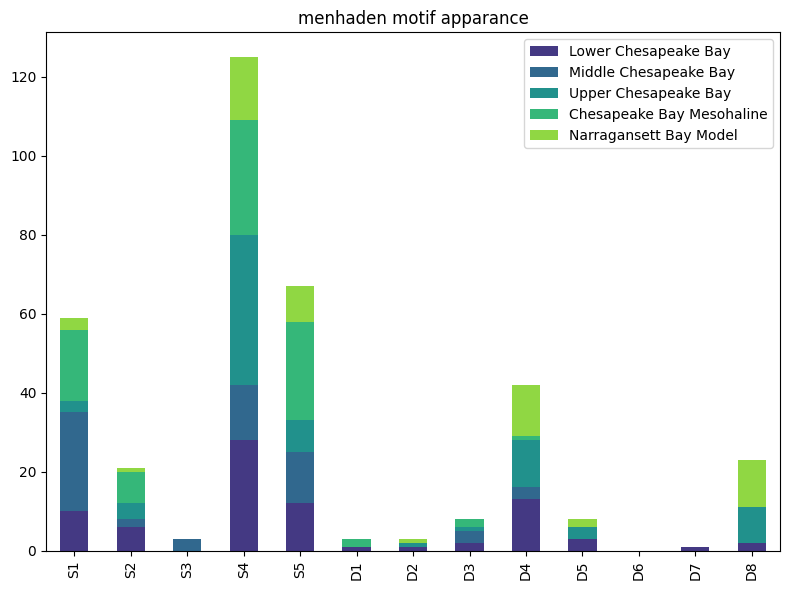

<Figure size 640x480 with 0 Axes>

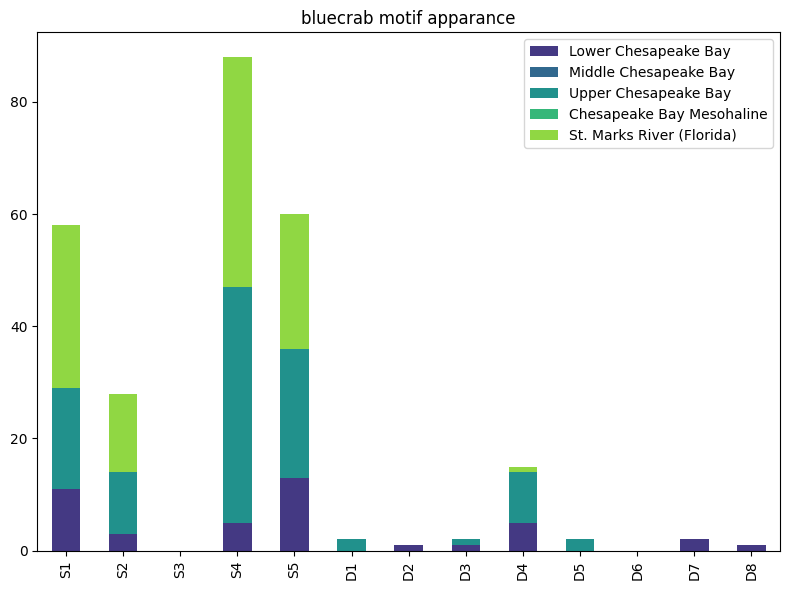

<Figure size 640x480 with 0 Axes>

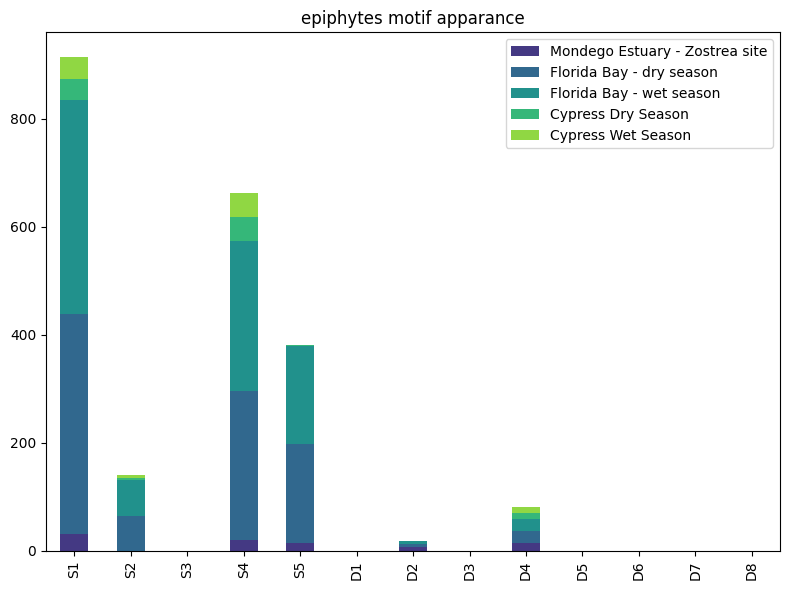

In [ ]:
#@title Plot the motif appearance of the Taxa
taxa_formatted_name = 'phytoplankton' #@param {type: 'string'}

taxas = ['phytoplankton', 'bayanchovy', 'meiofauna', 'catfish', 'zooplankton', 'freebacteria', 'spot', 'menhaden', 'bluecrab', 'epiphytes']

for taxa_formatted_name in taxas:
  out_path = f'../Taxa role/All nodes/{taxa_formatted_name}_all.pdf'
  create_folder(out_path)
  # collecting the datasets of the foodweb containing that taxa
  G_taxa_dataset = []
  for G in G_dataset:
    formatted_names = [v['name'].lower().replace(' ', '') for v in G.vs()]
    if taxa_formatted_name in formatted_names: G_taxa_dataset.append(G)

  motif_count = {}

  # collecting the motif representation of the taxa through the dataset:
  for G in G_taxa_dataset:
    #1. set the counter
    motif_count[G['name']] = {}
    for motif in load_motifs():
      motif_count[G['name']][motif] = 0

    #2. get the index
    formatted_names = np.array([v['name'].lower().replace(' ', '') for v in G.vs()])
    taxa_index = np.argwhere(formatted_names == taxa_formatted_name)[0][0]
    #3. first neighbours indices
    first_neighs = set(G.neighbors(taxa_index, mode='all'))
    #4. second neighbours indices
    second_neighs = set()
    for neigh_index in first_neighs:
      second_neighs = second_neighs.union(set(G.neighbors(neigh_index)))
    neighs = first_neighs.union(second_neighs)
    #5. add the taxa index and get the subgraph
    neighs.add(taxa_index)
    G_sub = G.subgraph(neighs)
    #6. triad apparence count
    triad_census = motif_contained_in_G(G_sub)[0]
    for motif in triad_census:
      for triad in triad_census[motif]['triads']:
        if taxa_formatted_name in [name.lower().replace(' ', '') for name in triad]:
          motif_count[G['name']][motif] += 1

  #3. plot
  df_plot = pd.DataFrame(motif_count)
  plt.figure()
  ax = df_plot.plot(kind='bar', stacked=True, color=sns.color_palette('viridis', n_colors=len(df_plot.columns)), figsize=(8, 6))
  ax.set_title(f'{taxa_formatted_name} motif apparance')
  plt.tight_layout()
  plt.savefig(out_path)

In [ ]:
formatted_names = np.array([v['name'].lower().replace(' ', '') for v in G.vs()])
taxa_index = np.argwhere(formatted_names == taxa_formatted_name)[0][0]
first_neighs = set(G.neighbors(taxa_index, mode='all'))
#4. second neighbours indices
second_neighs = set()
for neigh_index in first_neighs:
  second_neighs = second_neighs.union(set(G.neighbors(neigh_index)))
neighs = first_neighs.union(second_neighs)
#5. add the taxa index and get the subgraph
neighs.add(taxa_index)
G_sub = G.subgraph(neighs)


In [ ]:
neighs

{5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 16,
 44,
 46,
 48,
 49,
 50,
 52,
 54,
 55,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 65,
 67,
 68,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 96,
 100,
 115,
 119,
 121,
 122,
 123,
 124,
 130,
 132}

In [ ]:
name = 'Phytoplankton'
for index, v in enumerate(G.vs()):
  if v['name'] == name: break

indices = [index]
for v_id in G.neighbors(index):
  indices.append(v_id)
  print(G.neighbors(v_id))
indices

[5, 10, 13, 44, 46, 48, 57, 58, 60, 61, 62, 63, 65, 67, 68, 73, 74, 75, 76, 78, 79, 80, 84, 85, 86, 89, 89, 96, 100, 115, 121, 122, 123, 124, 130, 132]
[5, 6, 7, 8, 9, 10, 11, 12, 16, 46, 49, 50, 52, 54, 55, 57, 58, 59, 68, 76, 77, 78, 82, 83, 86, 87, 88, 89, 119, 130]


[130, 88, 115]